# By Miles - Data Scientist interview task

### Sam Dolman, July 2024#


Summary:
* We train a catboost (gradient boosted tree) model on a cleaned version of the dataset
* The resulting predictions are well calibrated, and explain much of the observed variance in quoted premiums
* Driver Age, Vehicle Age/Value, and NCD are the most important features
* Some feature engineering is performed, but much more can be done
* No hyperparam tuning or feature selection performed, but happy to discuss in detail how I would do this

# Imports / Global Variables

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.calibration import calibration_curve

from plotting_utils import interpret_feature

In [2]:
filename = 'ds_interview_task_data2.csv'

target_col = 'Avgpremium'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

np.random.seed(42)

# Data Import / Basic Cleaning / Exploration

<span style="color:orange">We read in the provided csv file, format with correct data types where required, and generate some simple summary plots to understand the data in each column
</span> 

In [3]:
df = pd.read_csv(filename, low_memory = False)
df

,Quoteid,Device,Age,Maritalstatus,employmentstatus,Childrenunder16,Licencetype,Lengthlicenceheld,Noclaimsdiscount,Anyprosecutions,...,Circumstanceinformation2,Quotetime,Fueltype,Homeowner,Gender,Vehicleage,Dayofbirth,Avgpremium,Unnamed: 32,Unnamed: 33
0,1,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,09:40,Diesel,Y,M,10.0,11.0,613.96,NaN,NaN
1,2,Desktop,25.0,Single,Unemployed,No,Full UK-Manual,0.0,No NCB,No,...,NaN,13:36,Petrol,N,M,15.0,2.0,"1,466.07",NaN,NaN
2,3,Desktop,32.0,Single,Employed,No,Full UK-Manual,120.0,9 Years,No,...,NaN,15:45,Petrol,N,M,15.0,14.0,293.22,NaN,NaN
3,4,Mobile,30.0,Single,Employed,No,Full UK-Manual,27.0,1 Year,No,...,NaN,00:01,Diesel,N,M,13.0,14.0,831.66,NaN,NaN
4,5,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,09:42,Diesel,Y,M,10.0,11.0,616.76,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="color:orange">It seems that many rows at the bottom of the csv are empty, as are the final two columns. Let's drop them:
</span> 

In [4]:
df = df.dropna(how='all').iloc[:, :-2].copy()
df

,Quoteid,Device,Age,Maritalstatus,employmentstatus,Childrenunder16,Licencetype,Lengthlicenceheld,Noclaimsdiscount,Anyprosecutions,...,Claimdate2,Claimamount2,Circumstanceinformation2,Quotetime,Fueltype,Homeowner,Gender,Vehicleage,Dayofbirth,Avgpremium
0,1,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,NaN,NaN,09:40,Diesel,Y,M,10.0,11.0,613.96
1,2,Desktop,25.0,Single,Unemployed,No,Full UK-Manual,0.0,No NCB,No,...,NaN,NaN,NaN,13:36,Petrol,N,M,15.0,2.0,"1,466.07"
2,3,Desktop,32.0,Single,Employed,No,Full UK-Manual,120.0,9 Years,No,...,NaN,NaN,NaN,15:45,Petrol,N,M,15.0,14.0,293.22
3,4,Mobile,30.0,Single,Employed,No,Full UK-Manual,27.0,1 Year,No,...,NaN,NaN,NaN,00:01,Diesel,N,M,13.0,14.0,831.66
4,5,Desktop,30.0,Living with partner / Common law,Employed,No,Full UK-Manual,144.0,4 Years,No,...,NaN,NaN,NaN,09:42,Diesel,Y,M,10.0,11.0,616.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463459,"463,460",Mobile,25.0,Single,Employed,No,Full UK-Manual,48.0,4 Years,No,...,NaN,NaN,NaN,17:15,Petrol,N,M,13.0,6.0,724.56
463460,"463,461",Desktop,58.0,Widowed,Employed,No,Full UK-Manual,241.0,11 Years (Currently Protected),No,...,NaN,NaN,NaN,18:02,Diesel,Y,F,6.0,9.0,433.96
463461,"463,462",Desktop,42.0,Living with partner / Common law,Employed,Yes,Full UK-Manual,180.0,12 Years,No,...,NaN,NaN,NaN,14:25,Electric,N,M,1.0,11.0,"1,222.22"
463462,"463,463",Desktop,62.0,Single,Self-Employed,No,Full UK-Manual,241.0,No NCB,No,...,NaN,NaN,NaN,18:03,Diesel,Y,M,19.0,25.0,457.99


<span style="color:orange">Next up, we check to see whether any columns have been encoded with an incorrect data type:
</span> 

In [5]:
# Check data types and summary statistics for each column:
for col in df.columns:
    print(df[col].describe())
    print('\n')

count     463464
unique    463464
top            1
freq           1
Name: Quoteid, dtype: object


count      463464
unique          6
top       Desktop
freq       235972
Name: Device, dtype: object


count    463464.000000
mean         37.310164
std          16.326457
min          16.000000
25%          23.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: Age, dtype: float64


count     463464
unique        15
top       Single
freq      201506
Name: Maritalstatus, dtype: object


count       463464
unique          18
top       Employed
freq        311916
Name: employmentstatus, dtype: object


count     463464
unique         4
top           No
freq      324373
Name: Childrenunder16, dtype: object


count             463464
unique                15
top       Full UK-Manual
freq              416913
Name: Licencetype, dtype: object


count    463336.000000
mean        122.662439
std          94.196345
min           0.000000
25%          32.000000
50%      

<span style="color:orange">**NCD, Vehicle Value, Mileage**, and **Vol Excess** need converting to integer type.

<span style="color:orange">As a quick and dirty first approach, extract any numbers from the string using regex, otherwise fill with zeros (if we had more time, would have custom treatment for special values, missing values, and other details such as protected NCD - but this is good enough for now)
</span> 

In [6]:
for col in ['Noclaimsdiscount', 'Vehiclevalue', 'Estimatedannualmileage', 'Voluntaryexcess']:
    print(df[col].value_counts()[:10])
    print('\n')
    df[col + '_clean'] = df[col].str.replace(r'\D', '', regex=True).replace('', pd.NA).fillna('0').astype(int)
    df.drop(columns = col, inplace = True)
    print(df[col + '_clean'].value_counts()[:10])
    print('\n')

Noclaimsdiscount
No NCB                             106648
1 Year                              48959
2 Years                             36104
3 Years                             28944
20+ years (Currently Protected)     24332
4 Years                             20886
5 Years                             16105
10 Years (Currently Protected)      15510
9 Years (Currently Protected)       14923
20+ years                           11975
Name: count, dtype: int64


Noclaimsdiscount_clean
0     112424
1      48991
2      36652
20     36329
3      28969
10     25803
9      25385
4      24758
5      21974
6      16180
Name: count, dtype: int64


Vehiclevalue
>40000    8750
2,000     5208
1,000     5023
1,500     4631
3,000     4109
2,500     3615
2,195     3484
5,000     3337
4,000     3284
2,295     3249
Name: count, dtype: int64


Vehiclevalue_clean
40000    9361
2000     5208
1000     5023
1500     4631
3000     4109
2500     3615
2195     3484
5000     3337
4000     3284
2295     3249
Name

<span style="color:orange">**Vehiclepurchasedate** and **Quotetime** are date/time fields encoded as strings. To get at least some use from these, we respectively extract the year/hour.
</span> 

In [7]:
df['Vehiclepurchaseyear'] = df['Vehiclepurchasedate'].str.extract(r'\/(\d{4})').fillna(0).astype(int)
df['Quotehour'] = df['Quotetime'].str.extract(r'(\d{2})').fillna(0).astype(int)
df.drop(columns = ['Vehiclepurchasedate', 'Quotetime'], inplace = True)

print(df['Vehiclepurchaseyear'].value_counts()[:10])
print('\n')
print(df['Quotehour'].value_counts()[:10])

Vehiclepurchaseyear
0       142272
2021     96995
2020     61844
2022     46913
2019     40192
2018     24880
2017     16494
2016     10471
2015      7029
2014      4505
Name: count, dtype: int64


Quotehour
14    37610
15    37388
16    31874
0     28649
13    23873
17    23014
12    21583
11    20941
10    20406
9     20374
Name: count, dtype: int64


<span style="color:orange">The **target column** also needs converting to numeric. Here, need to take care of decimal places, and also drop the three rows with missing target:

In [8]:
# encode target col as numeric
df[target_col] = df[target_col].str.replace(',', '').astype(float)
df = df.loc[~df[target_col].isna()]

df[target_col]

0          613.96
1         1466.07
2          293.22
3          831.66
4          616.76
           ...   
463459     724.56
463460     433.96
463461    1222.22
463462     457.99
463463    7340.36
Name: Avgpremium, Length: 463461, dtype: float64

<span style="color:orange">There are also some **outliers** in the target column. Let's remove them:

In [9]:
lower = 1
upper = 1e5

print(f'{(~df[target_col].between(lower, upper)).sum()} outliers were removed')
df = df.loc[df[target_col].between(lower, upper)]

9117 outliers were removed


<span style="color:orange">For the various **claim** columns, a thorough treatment would involve extensive feature engineering to create multiple columns such as 'number of fault claims within 1/2/3 years' etc.

<span style="color:orange">To save time we will **ignore the claim date fields**, and simply use the remaining claim fields as they come (with appropriate missing value where no claim has occured) to pick up the effect of claims on quote price. This is obviously not the best approach!

<span style="color:orange">(claim amounts will be converted to numeric, as above)

In [10]:
# remove claim date columns
df.drop(columns = ['Claimdate1', 'Claimdate2'], inplace = True)

# transform claim amount columns to numeric
for col in ['Claimamount1', 'Claimamount2']:
    df[col] = df[col].str.replace(',', '').astype(float).fillna(0)

<span style="color:orange">Also note that many of the remaining categorical columns contain **duplicate levels**, with quotation marks - e.g. 'No' and '"No"' appearing as distinct levels. Let's quickly fix that:

In [11]:
for col in df.select_dtypes(include=['object']).columns[1:]:
    df[col] = df[col].str.replace('"', '', regex=False)

<span style="color:orange">With the basic cleaning complete, we can now visualise the distributions:

<span style="color:orange">Everything mostly looks as we'd expect!

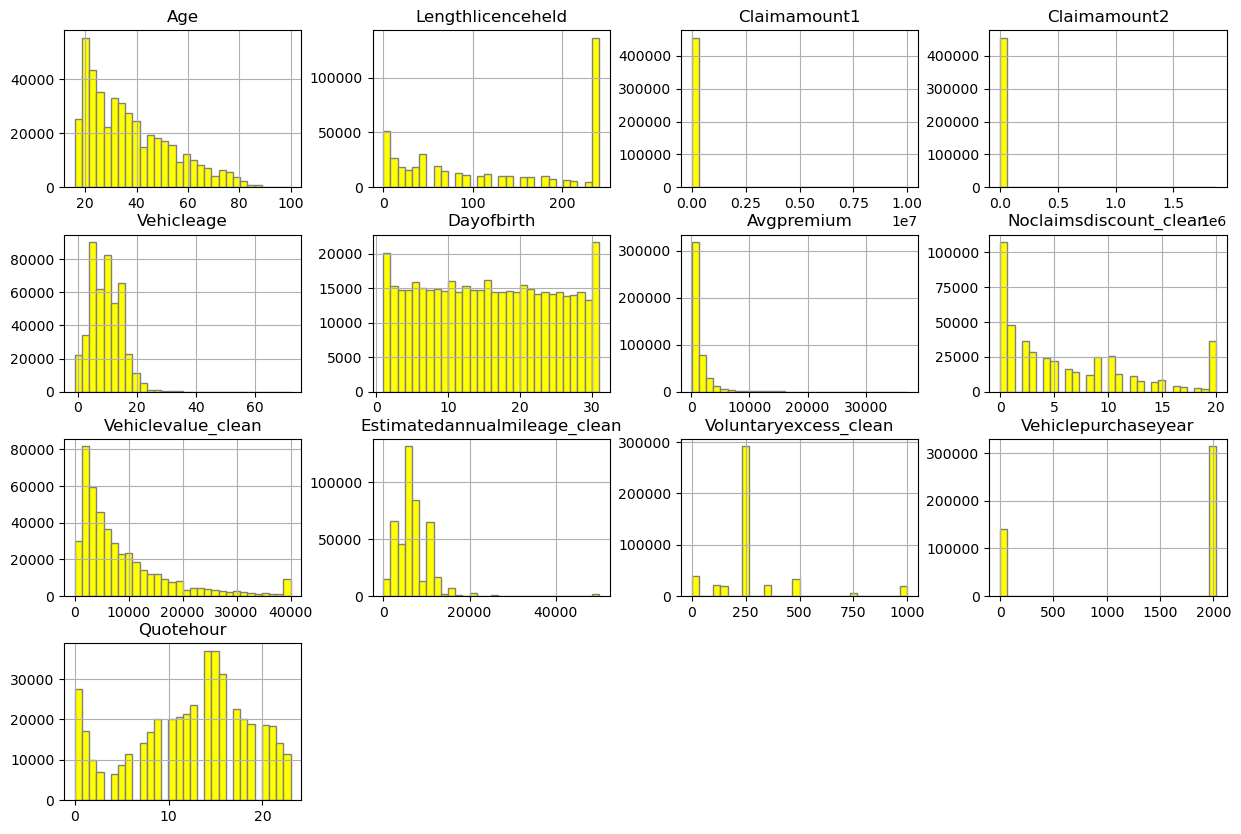

In [12]:
# Histograms for numerical columns
df.hist(bins=30, figsize=(15, 10), color = 'yellow', edgecolor = 'grey')
plt.show()

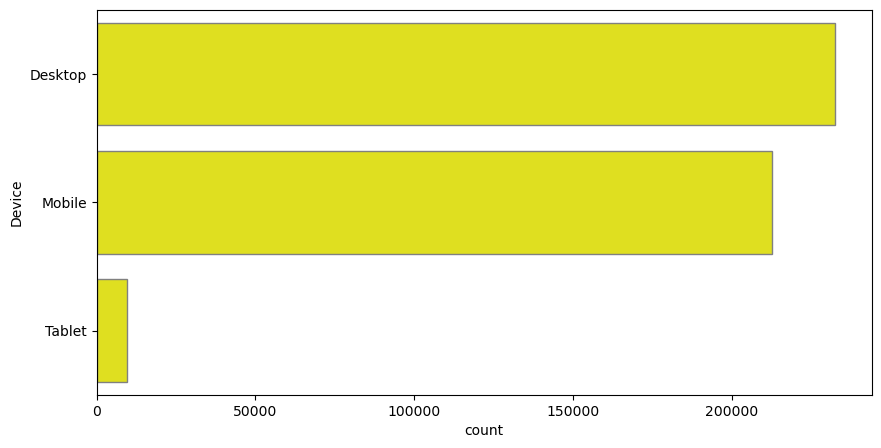

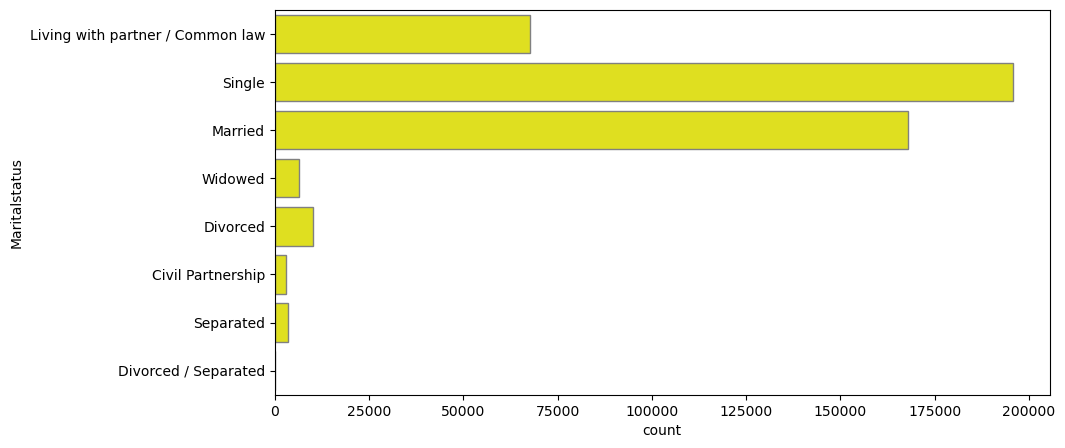

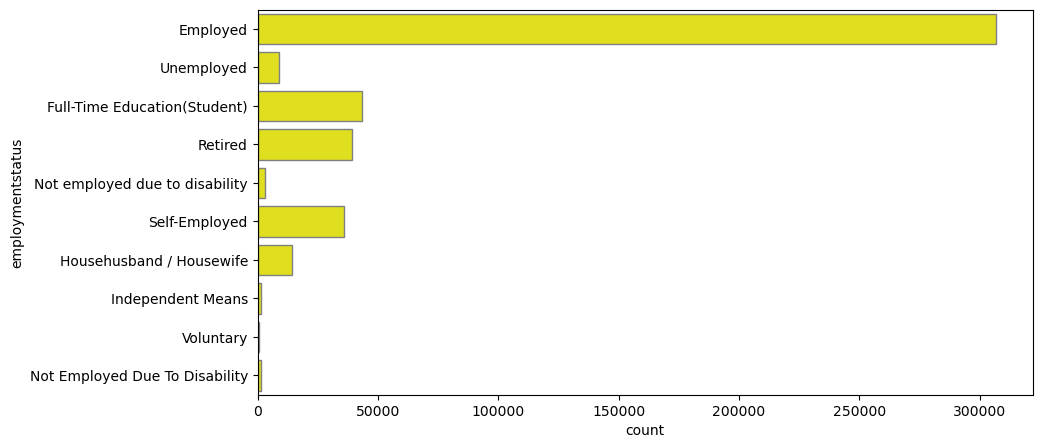

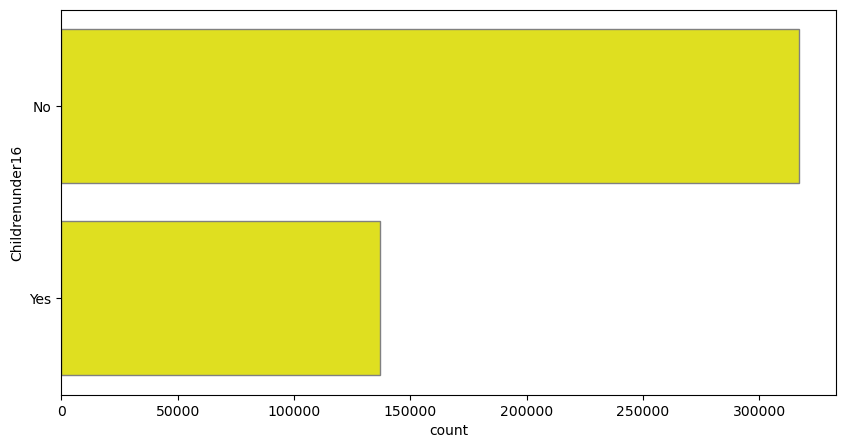

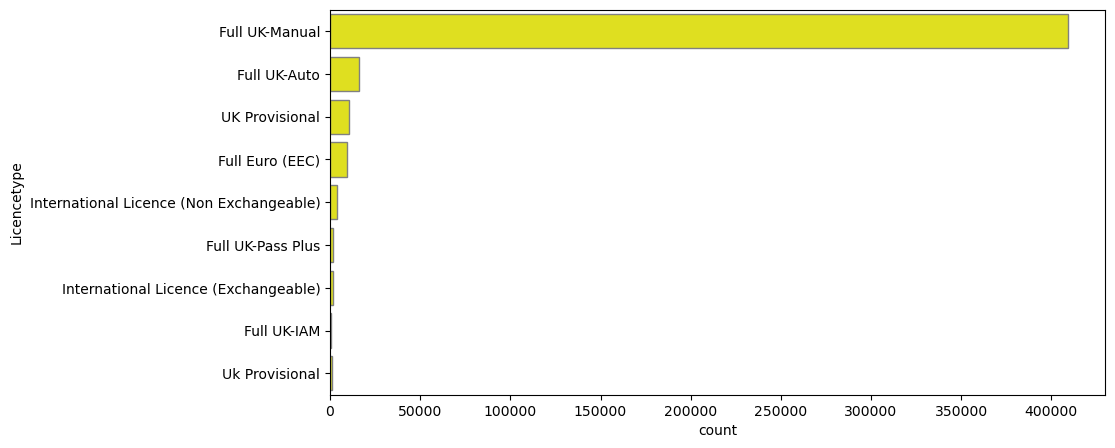

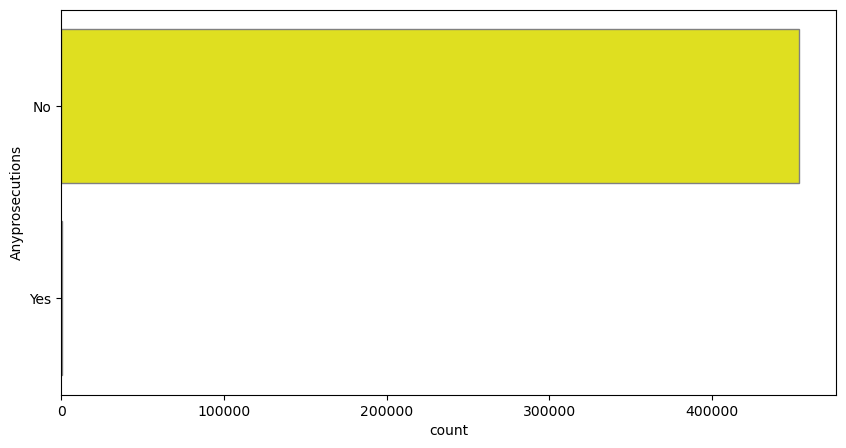

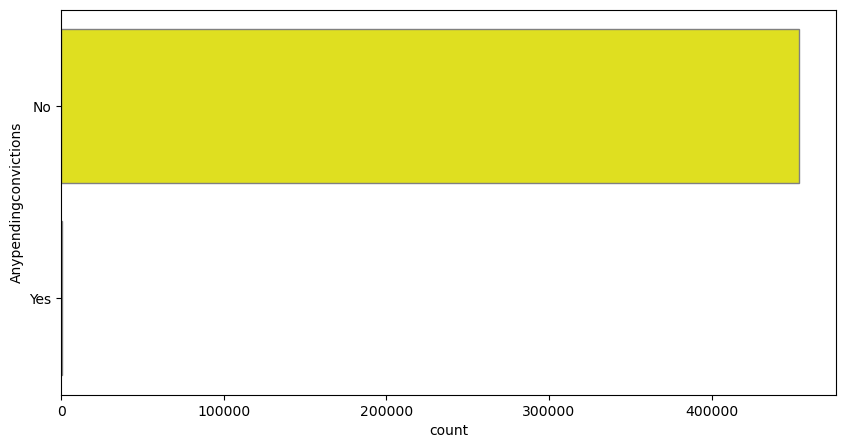

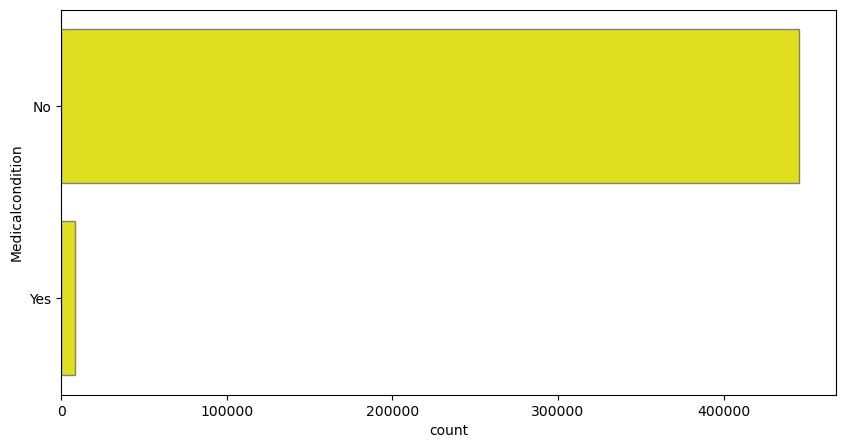

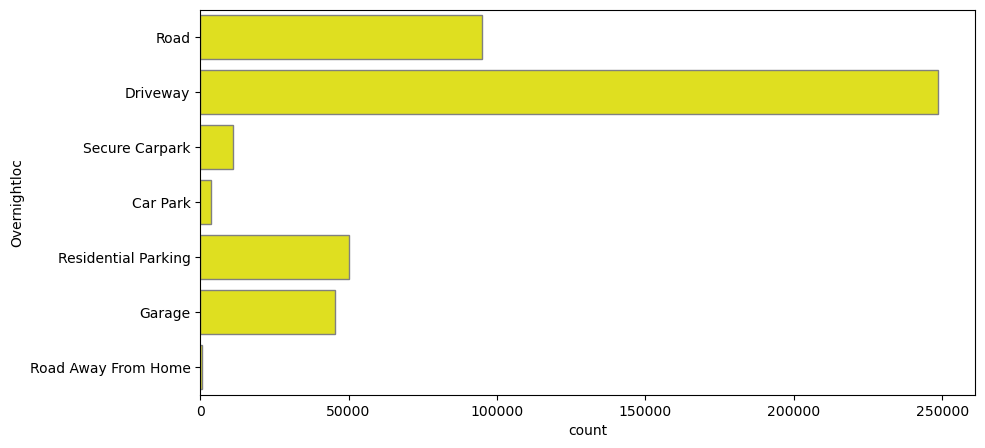

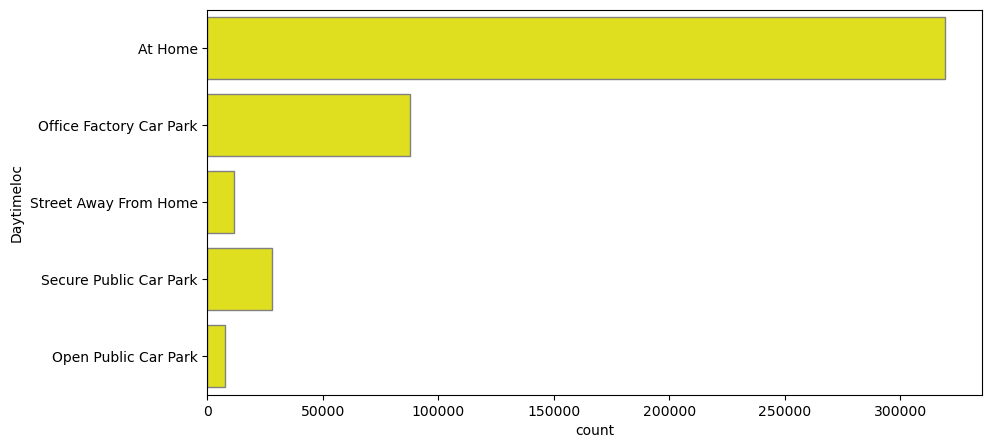

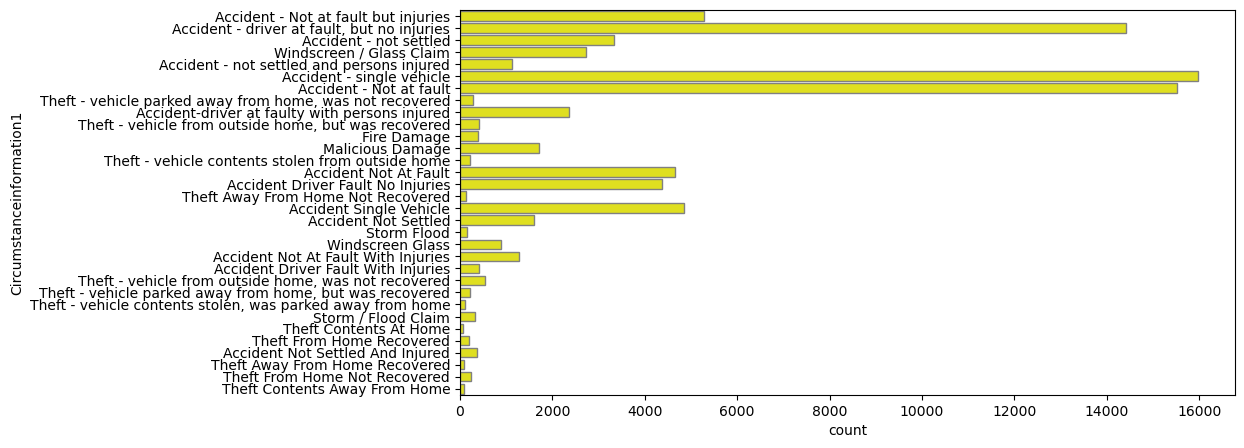

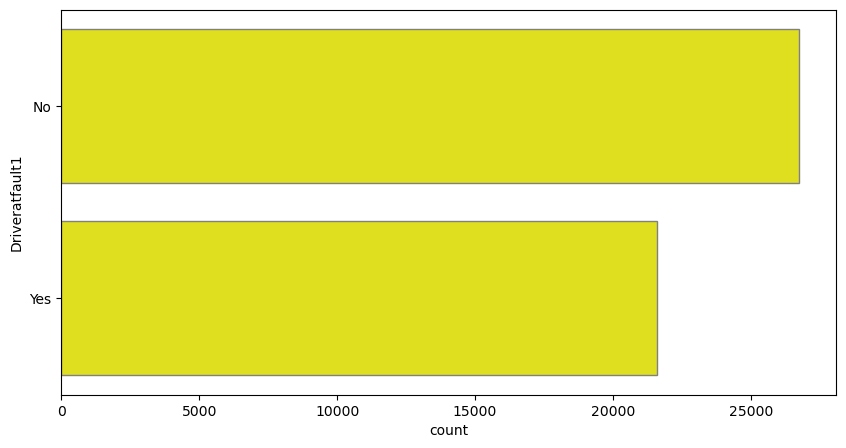

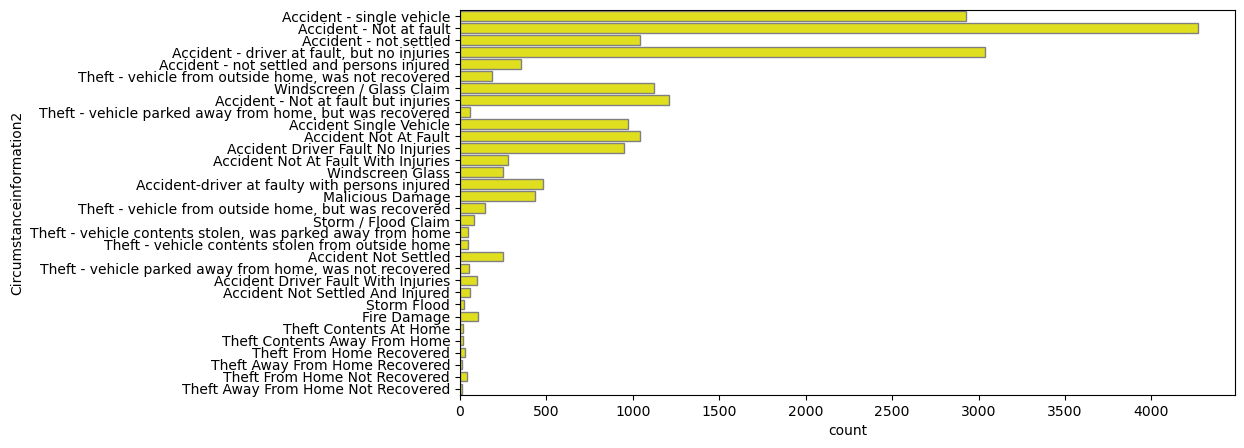

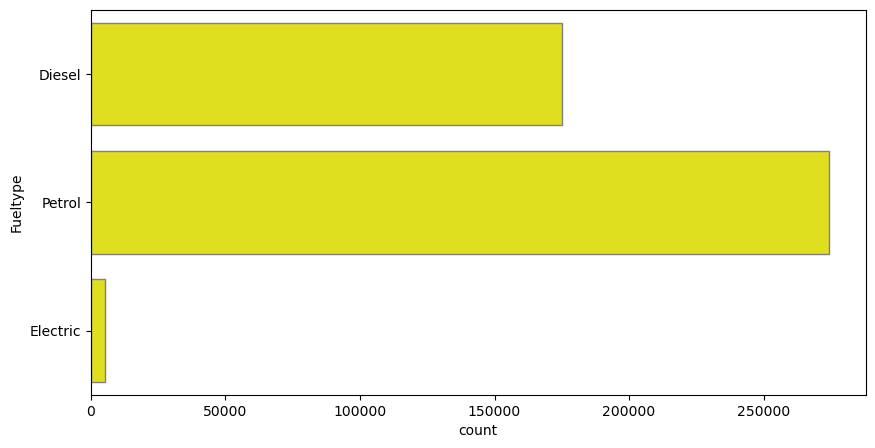

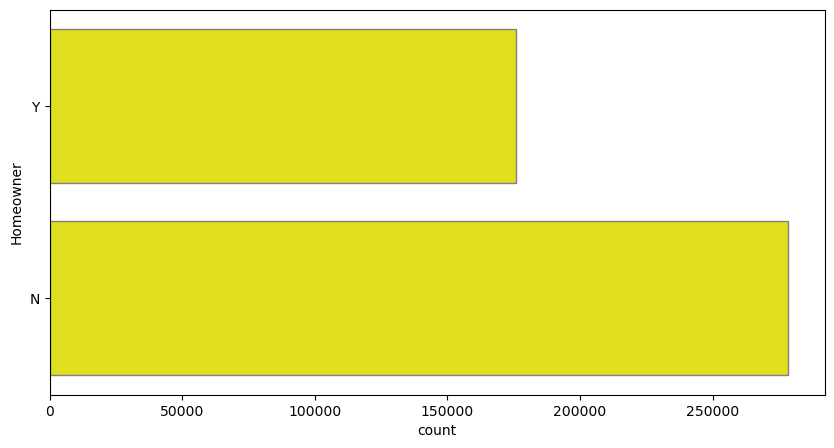

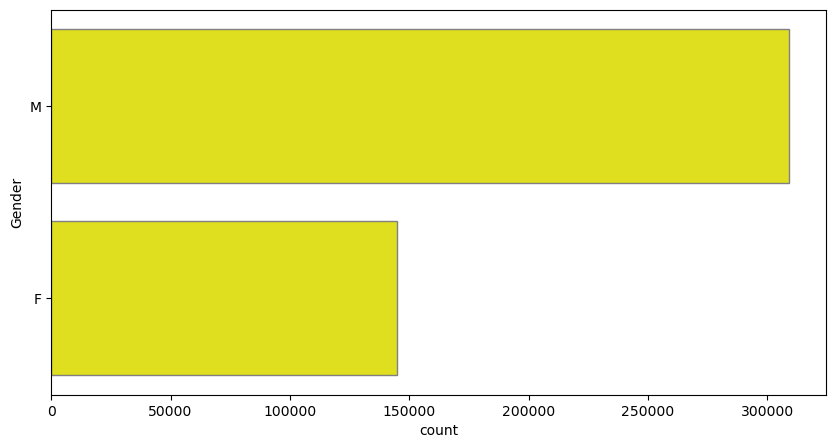

In [13]:
# Bar plots for categorical columns
for column in df.select_dtypes(include=['object']).columns[1:]:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=column, data=df, color = 'yellow', edgecolor = 'grey')
    plt.show()

<span style="color:orange"> The median value for **Avgpremium** is around £1400, with most quotes between £400 and £1500. The distribution is right skewed (as expected), so a Gamma or Log-Normal distribution may be appropriate

count    454344.000000
mean       1386.015739
std        2069.195862
min          93.310000
25%         409.250000
50%         736.000000
75%        1579.242500
max       37141.010000
Name: Avgpremium, dtype: float64


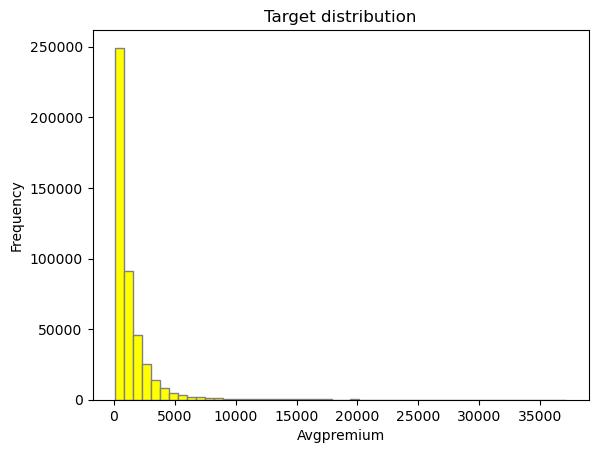

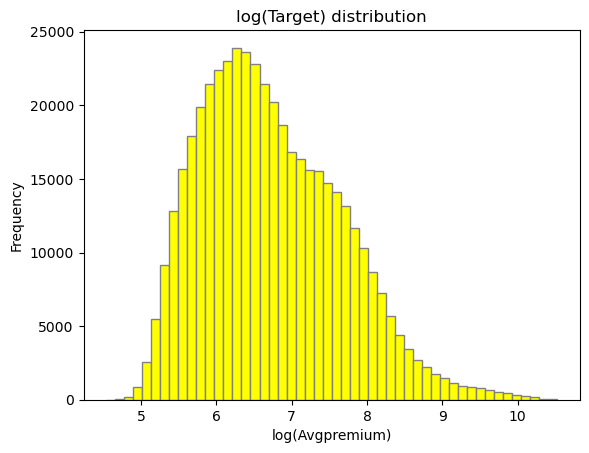

In [14]:
print(df[target_col].describe())

plt.hist(df[target_col], bins = 50, color = 'yellow', edgecolor = 'grey')
plt.xlabel(f'{target_col}')
plt.ylabel('Frequency')
plt.title('Target distribution')
plt.show()


plt.hist(np.log(df[target_col]), bins = 50, color = 'yellow', edgecolor = 'grey')
plt.xlabel(f'log({target_col})')
plt.ylabel('Frequency')
plt.title('log(Target) distribution')

plt.show()

# Additional Data Prep + Feature Engineering

* <span style="color:orange">Remove innapporpriate features
* <span style="color:orange">Custom feature engineering
* <span style="color:orange">Categorical encoding (NOT REQUIRED - as we are using catboost)
* <span style="color:orange">Treatment of missing values
* <span style="color:orange">Train/val/test split

<span style="color:orange">Some features **should not be included** in the model. Let's get rid of them:
* <span style="color:orange"> Cannot use **gender** to set insurance premiums (EU/FCA regs)
* <span style="color:orange"> **Dayofbirth** - we will use driver age in yearsm rather than use exact birthday
*  <span style="color:orange"> **Quoteid** - this is a unique identifier, and should not be included in a model

In [15]:
disallowed_features = ['Gender', 'Dayofbirth', 'Quoteid']

df.drop(columns = disallowed_features, inplace = True)

<span style="color:orange">Adding in **engineered features**:

* <span style="color:orange">Domain knowledge can often be used to manually create new features using the provided raw features. One example is vehicle age at purchase - does a customer who buys new cars behave differently to a customer who buys secondhand cars?


* <span style="color:orange">Many more features are possible, only this single example is included here

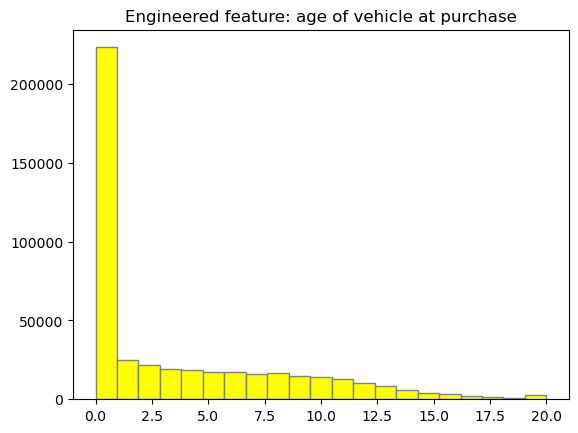

In [16]:
# Vehicle age at purchase
df['Vehicle_age_at_purchase'] = df['Vehicleage'] - (2024 - df['Vehiclepurchaseyear'])
df['Vehicle_age_at_purchase'] = df['Vehicle_age_at_purchase'].clip(lower = 0, upper = 20)


plt.hist(df['Vehicle_age_at_purchase'], bins = 21, color = 'yellow', edgecolor = 'grey')
plt.title('Engineered feature: age of vehicle at purchase')
plt.show()

<span style="color:orange"> **Missing imputation** - fill NAs in numeric columns with 0, categorical missing values with 'MI'

<span style="color:orange">More care would be taken here if time allowed! Important to distinguish between missing values, default values, missing at random etc. Separate missing_indicator features are often required.

In [17]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values in numeric columns with 0
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill missing values in categorical columns with 'MI'
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].fillna('MI')

Device                               0
Age                                  0
Maritalstatus                        0
employmentstatus                     0
Childrenunder16                      0
Licencetype                          0
Lengthlicenceheld                  126
Anyprosecutions                      0
Anypendingconvictions                0
Medicalcondition                     0
Overnightloc                         0
Daytimeloc                           0
Claimamount1                         0
Circumstanceinformation1        369973
Driveratfault1                  405979
Claimamount2                         0
Circumstanceinformation2        434674
Fueltype                             0
Homeowner                            0
Vehicleage                           0
Avgpremium                           0
Noclaimsdiscount_clean               0
Vehiclevalue_clean                   0
Estimatedannualmileage_clean         0
Voluntaryexcess_clean                0
Vehiclepurchaseyear      

<span style="color:orange"> Here we define our holdout samples.

<span style="color:orange">(note that with more complicated forms of missing imputation/feature engineering, need to beware of target leakage - so we should do this **after** train test split. But not an issue here)

* <span style="color:orange">**Train** - used to fit the model

* <span style="color:orange">**Validation** - used for early stopping, and model selection (e.g. hyperparm tuning / feature selection, if implemented)

* <span style="color:orange">**Test** - used to evaluate performance of the final model

In [18]:
# Calculate intended sizes for each set
total_size = len(df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)

# Create train / val / test sets, using randomly shuffled indices
indices = np.random.permutation(total_size)
train_df = df.iloc[indices[:train_size]]
val_df = df.iloc[indices[train_size:train_size + val_size]]
test_df = df.iloc[indices[train_size + val_size:]]

# Display the sizes of the resulting sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 318040
Validation set size: 68151
Test set size: 68153


# Model Training

* <span style="color:orange">We will use **catboost**, a gradient boosting algorithm with built-in support for categorical features (so we don't have to encode these manually)
* <span style="color:orange">Tweedie loss function with dispersal parameter 1.99 is supported, and very close to Gamma (we could also use lognormal or similar)
* <span style="color:orange">Early stopping is implemented using our validation set, to prevent overfitting (kicks in after ~1000 iterations)
* <span style="color:orange">Default hyperparameters are used, but tuning would be straightfoward (depth / lr / col_sample / row_sample / regularisation etc)

In [19]:
# Define our model features
features = list(train_df.columns)
features.remove(target_col)
cat_features = list(train_df.select_dtypes(include=['object']).columns)

# Initialize the model
model = CatBoostRegressor(iterations            = 1500,   # Maximum number of iterations
                          depth                 = 6,      # Depth of the trees
                          learning_rate         = 0.2,    # Learning rate
                          eval_metric           = 'RMSE', # Metric for early stopping
                          early_stopping_rounds = 50,     # Early stopping criteria
                          random_seed           = 42,
                          loss_function = 'Tweedie:variance_power=1.99', # This is as close to a gamma distribution as catboost allows
                         )

# Fit the model on training data, with validation data for early stopping
model.fit(train_df[features],
          train_df[target_col],
          cat_features=cat_features,
          eval_set=(val_df[features],
                    val_df[target_col]),
          verbose=100)

# Make Predictions
train_preds = model.predict(train_df[features])
val_preds = model.predict(val_df[features])
test_preds = model.predict(test_df[features])

0:	learn: 2502.5302356	test: 2452.5414886	best: 2452.5414886 (0)	total: 118ms	remaining: 2m 56s
100:	learn: 2498.4735157	test: 2448.4548463	best: 2448.4547256 (99)	total: 4.41s	remaining: 1m 1s
200:	learn: 2498.4583112	test: 2448.4410429	best: 2448.4410429 (200)	total: 8.85s	remaining: 57.2s
300:	learn: 2498.4530702	test: 2448.4376832	best: 2448.4376813 (298)	total: 13.2s	remaining: 52.5s
400:	learn: 2498.4502197	test: 2448.4359945	best: 2448.4359330 (392)	total: 17.6s	remaining: 48.2s
500:	learn: 2498.4476920	test: 2448.4349359	best: 2448.4348214 (487)	total: 22s	remaining: 43.8s
600:	learn: 2498.4462200	test: 2448.4345423	best: 2448.4345016 (596)	total: 26.5s	remaining: 39.6s
700:	learn: 2498.4452164	test: 2448.4345083	best: 2448.4343193 (673)	total: 31s	remaining: 35.4s
800:	learn: 2498.4438296	test: 2448.4341544	best: 2448.4341539 (799)	total: 35.5s	remaining: 31s
900:	learn: 2498.4427124	test: 2448.4336954	best: 2448.4336245 (897)	total: 40s	remaining: 26.6s
Stopped by overfitting

# Model Validation / Interpretation

<span style="color:orange"> **Performance metrics**
* <span style="color:orange">How well does our model perform (on test set)?
* <span style="color:orange">Our model explains around **38%** of the observed variation in quoted premiums, which is ok (but not great)
* <span style="color:orange">Mean absolute error **£658** - this is high in comparison to the median premium of £1400, although will be influenced by outliers
* <span style="color:orange">Train set metrics are only a little better - this suggests we have done well in **preventing too much overfitting**

In [20]:
r2 = r2_score(test_df[target_col], test_preds)
rmse = root_mean_squared_error(test_df[target_col], test_preds)
mae = abs(test_df[target_col] - test_preds).mean()

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

Test R²: 0.3828
Test RMSE: 1608.19
Test MAE: 658.00


In [21]:
r2 = r2_score(train_df[target_col], train_preds)
rmse = root_mean_squared_error(train_df[target_col], train_preds)
mae = abs(train_df[target_col] - train_preds).mean()

print(f"Train R²: {r2:.4f}")
print(f"Train RMSE: {rmse:.2f}")
print(f"Train MAE: {mae:.2f}")

Train R²: 0.4272
Train RMSE: 1575.41
Train MAE: 640.85


<span style="color:orange"> **Calibration / distribution check**
* <span style="color:orange"> Do our model predictions follow roughly the same distribution as the underlying data (**yes** - although with narrower spread)
* <span style="color:orange"> Are our predictions well calibrated? (**yes** - at least at the lower end)

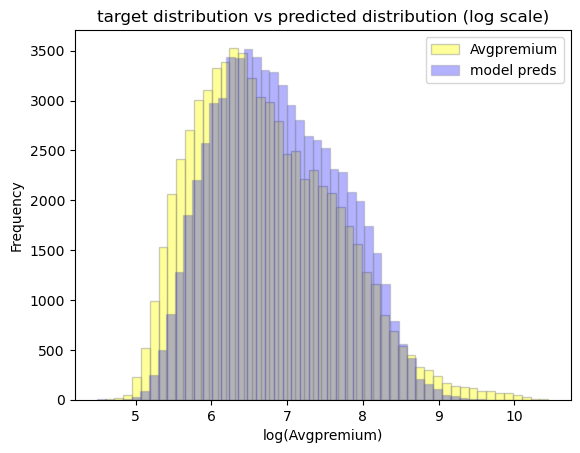

In [22]:
plt.hist(np.log(test_df[target_col]), bins = 50, color = 'yellow', edgecolor = 'grey', label = target_col, alpha = 0.4)
plt.hist(np.log(test_preds), bins = 50, color = 'blue', edgecolor = 'grey', label = 'model preds', alpha = 0.3)
plt.xlabel(f'log({target_col})')
plt.ylabel('Frequency')
plt.legend()
plt.title('target distribution vs predicted distribution (log scale)')

plt.show()

/tmp/ipykernel_243452/1117462531.py:6: RuntimeWarning: Mean of empty slice.
  bin_means_pred = [test_preds[bin_indices == i].mean() for i in range(1, len(bins))]
/home/majikthise/miniconda3/envs/takehome/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


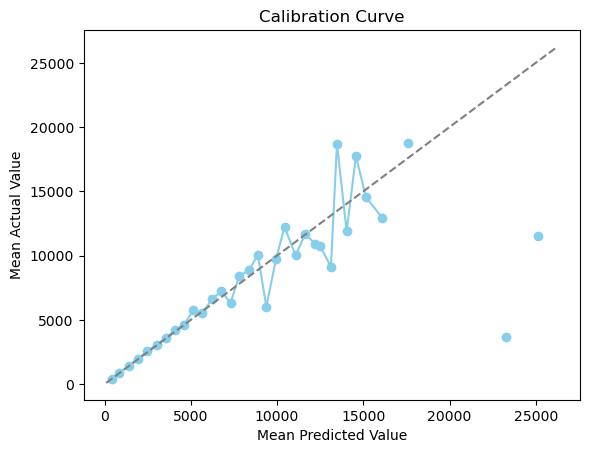

In [23]:
# Bin the predicted values
bins = np.linspace(min(test_preds), max(test_preds), 50)
bin_indices = np.digitize(test_preds, bins)

# Calculate mean predicted and actual values for each bin
bin_means_pred = [test_preds[bin_indices == i].mean() for i in range(1, len(bins))]
bin_means_actual = [test_df[target_col][bin_indices == i].mean() for i in range(1, len(bins))]

# Plot calibration curve
#plt.figure(figsize=(10, 6))
plt.plot(bin_means_pred, bin_means_actual, marker='o', linestyle='-', color='skyblue')
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Mean Actual Value')
plt.title('Calibration Curve')
plt.show()

<span style="color:orange"> **Feature Importance**
* <span style="color:orange">These come from catboost itself, and are based on each feature's splitting power within the trees
* <span style="color:orange">Empirical methods are often more useful, but take longer to calculate (e.g. leave-one-out feature importance, shuffle importance etc)
* <span style="color:orange">We see that **Vehicle age**/purchase year, **Driver Age**, **Vehicle value**, and **NCD** are among the most important features in determining the average quoted premium. This is what we would expect - these are certainly important features that all insurers will use to set their prices
* <span style="color:orange">Our manually crafted feature (**vehicle_age_at_purchase**) was not very high up, but better than some!
* <span style="color:orange">We could use this (and other methods) to select a subset of features for the final model

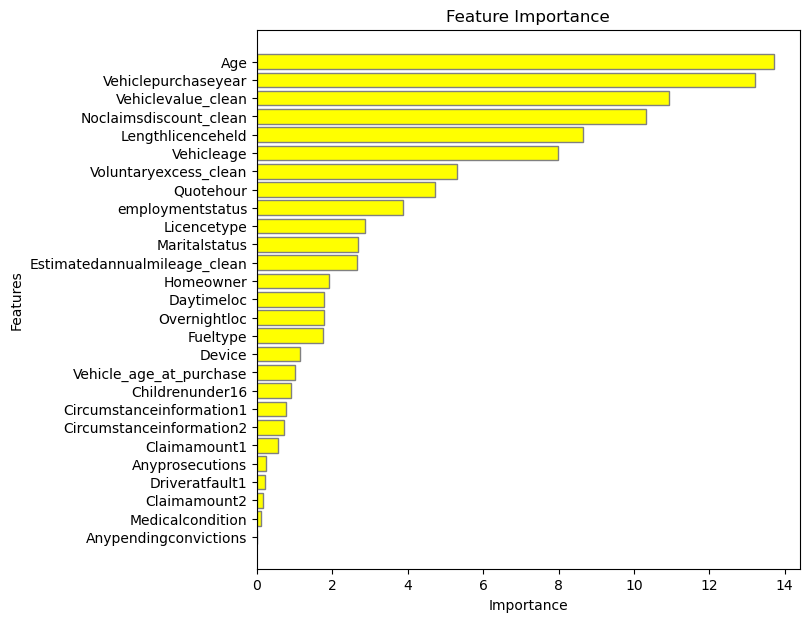

In [24]:
feature_importances = pd.DataFrame({'Feature': model.feature_names_,
                                     'Importance': model.feature_importances_})
feature_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

plt.figure(figsize=(7, 7))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='yellow', edgecolor ='grey')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

<span style="color:orange"> **Feature Interpretations**
* <span style="color:orange">I did NOT build this part during the 2-3 hours it took to complete the main task - this is based on code I wrote 'for fun' a couple of years ago!
* <span style="color:orange">Included purely for interest, an 'Emblem style' summary plot (with Partial Dependencies in place of GLM coefficients) for each feature

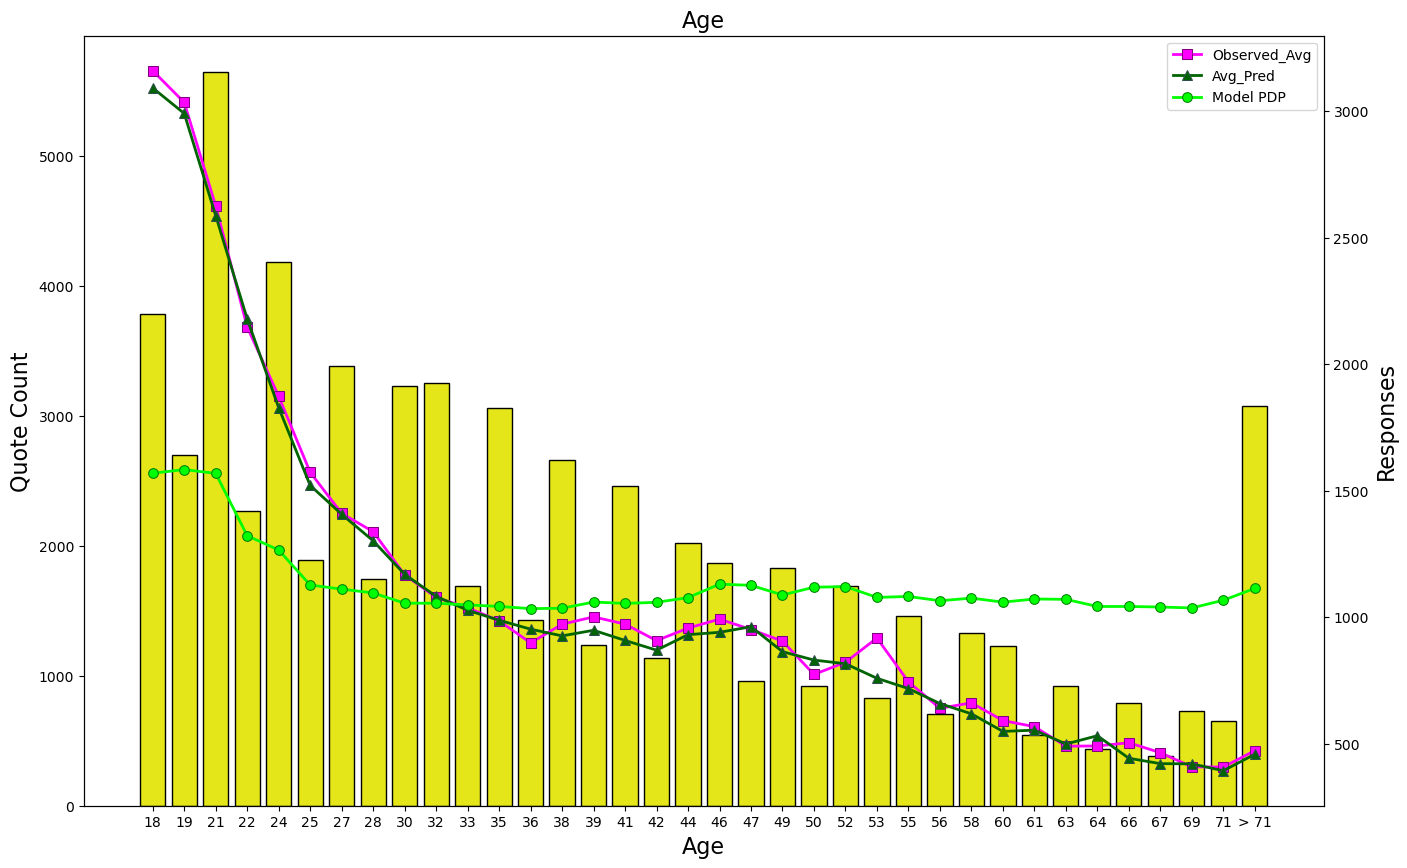

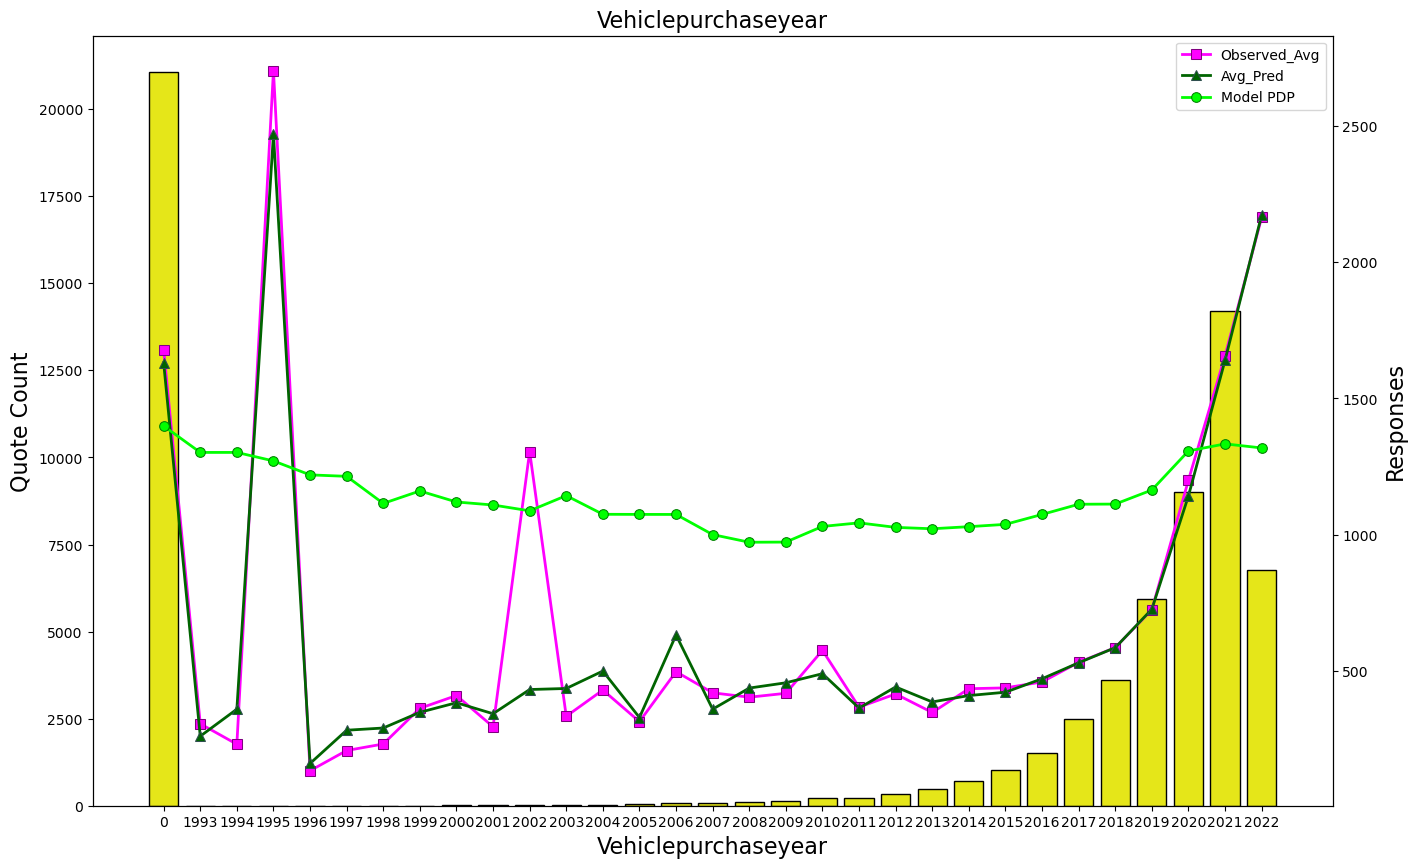

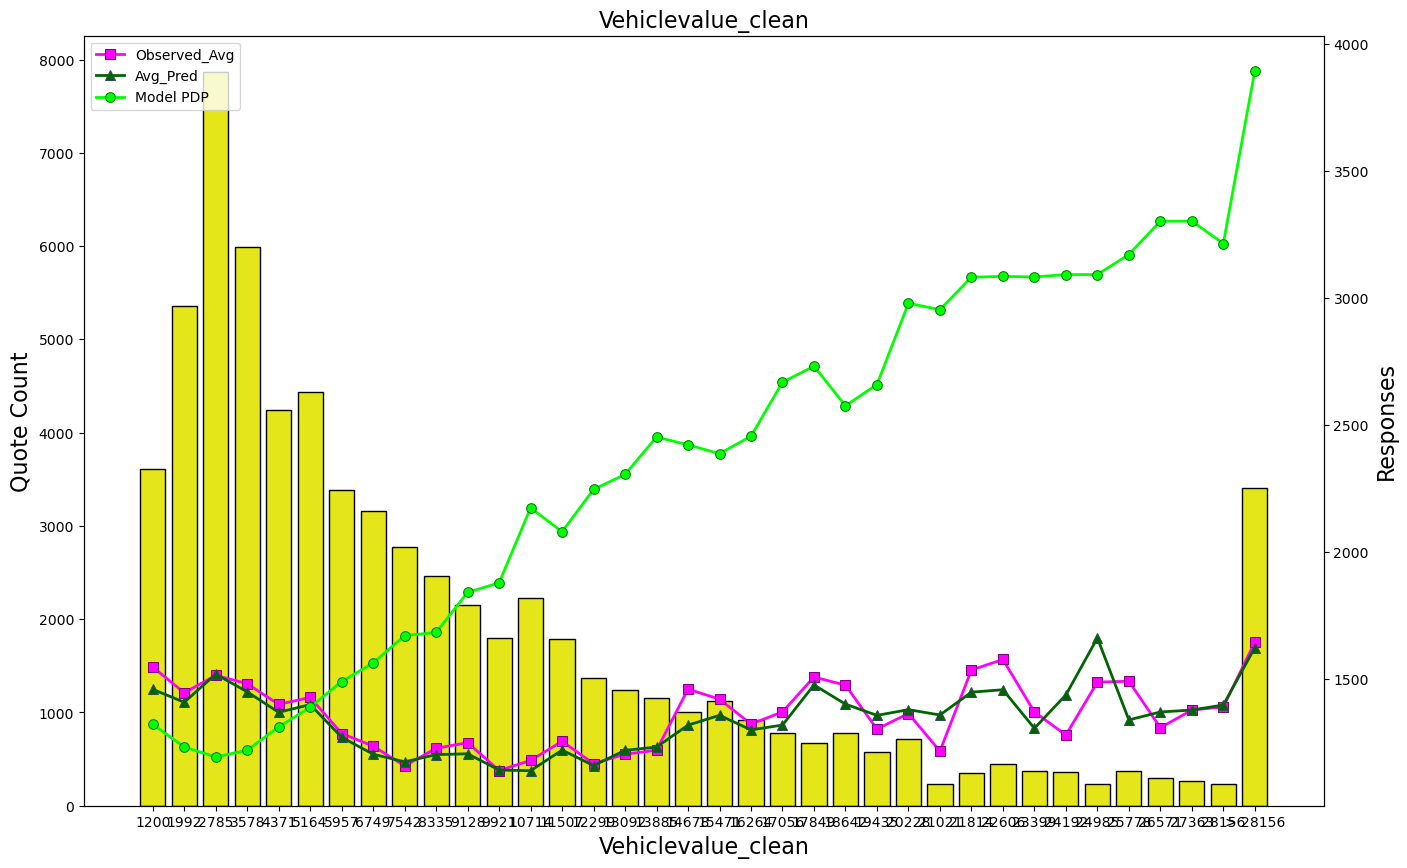

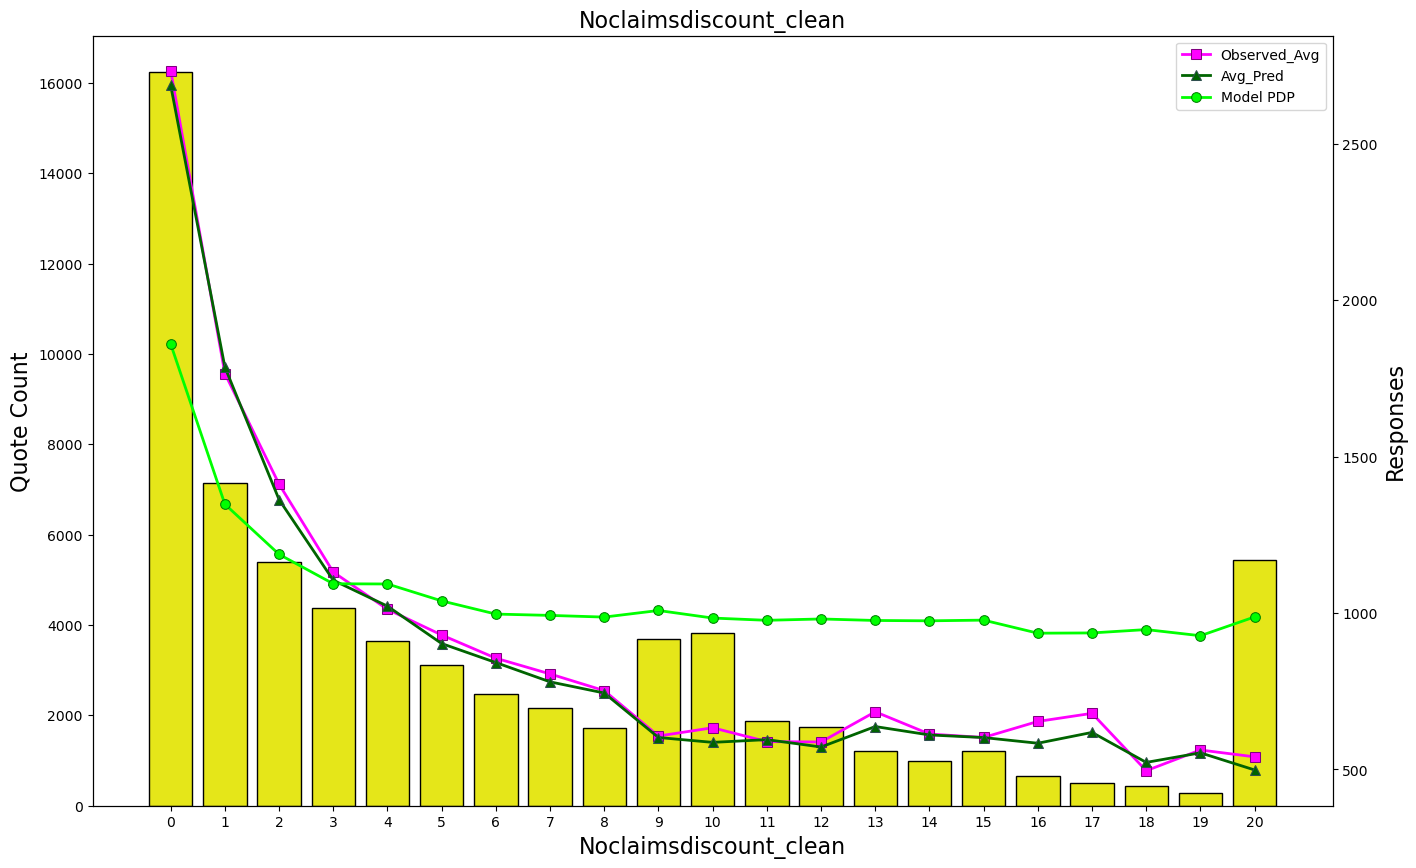

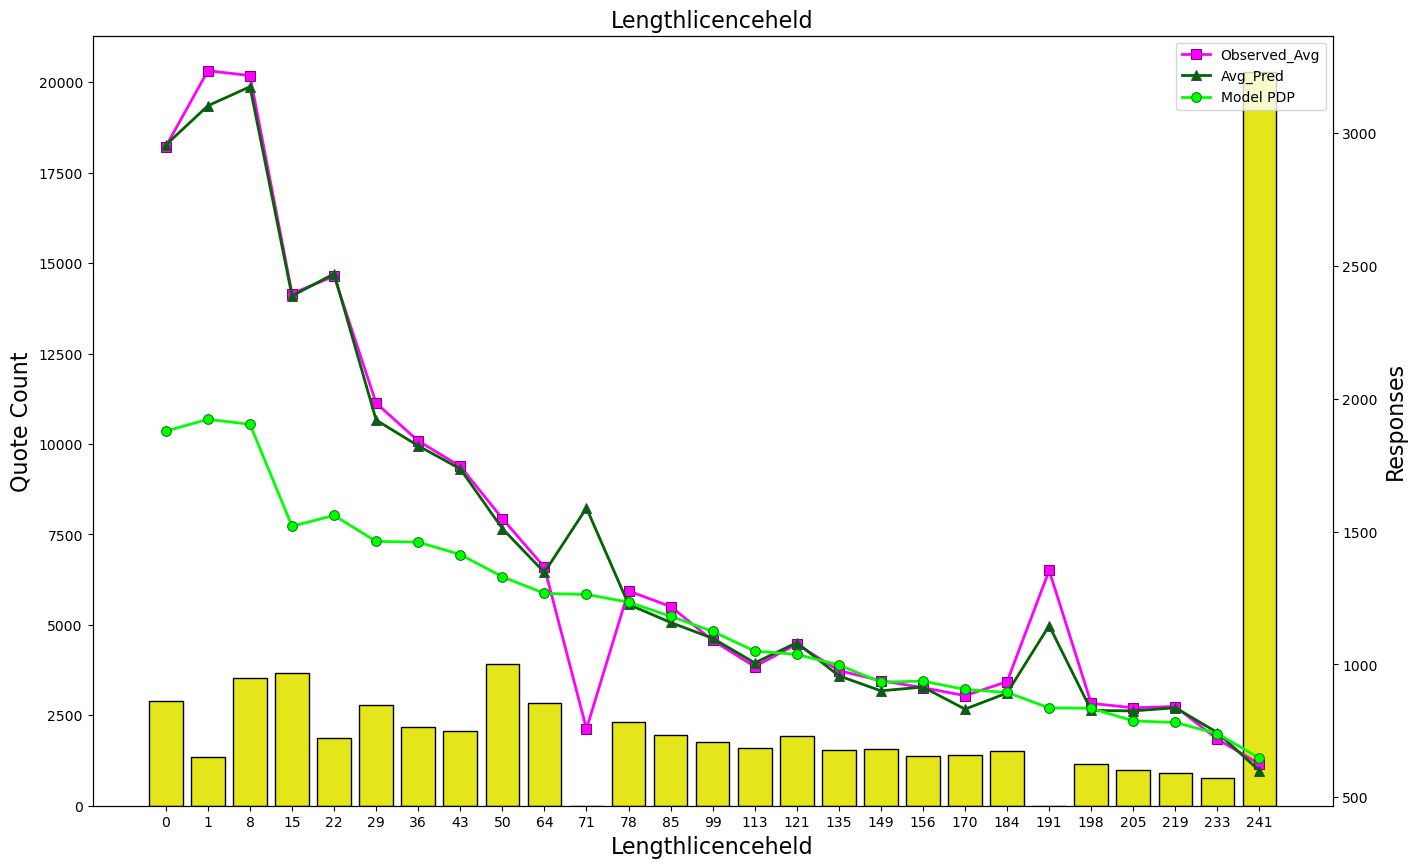

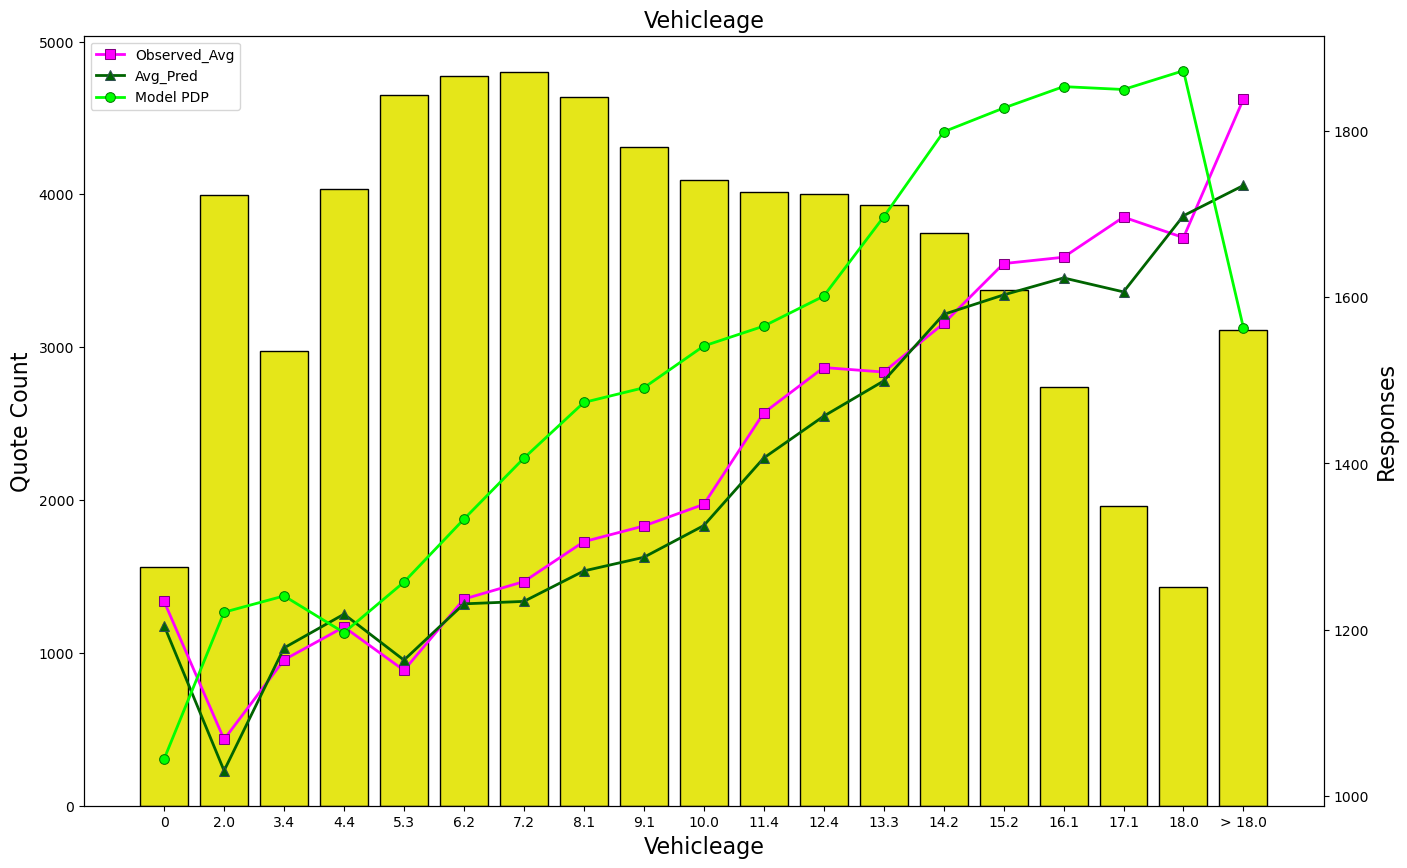

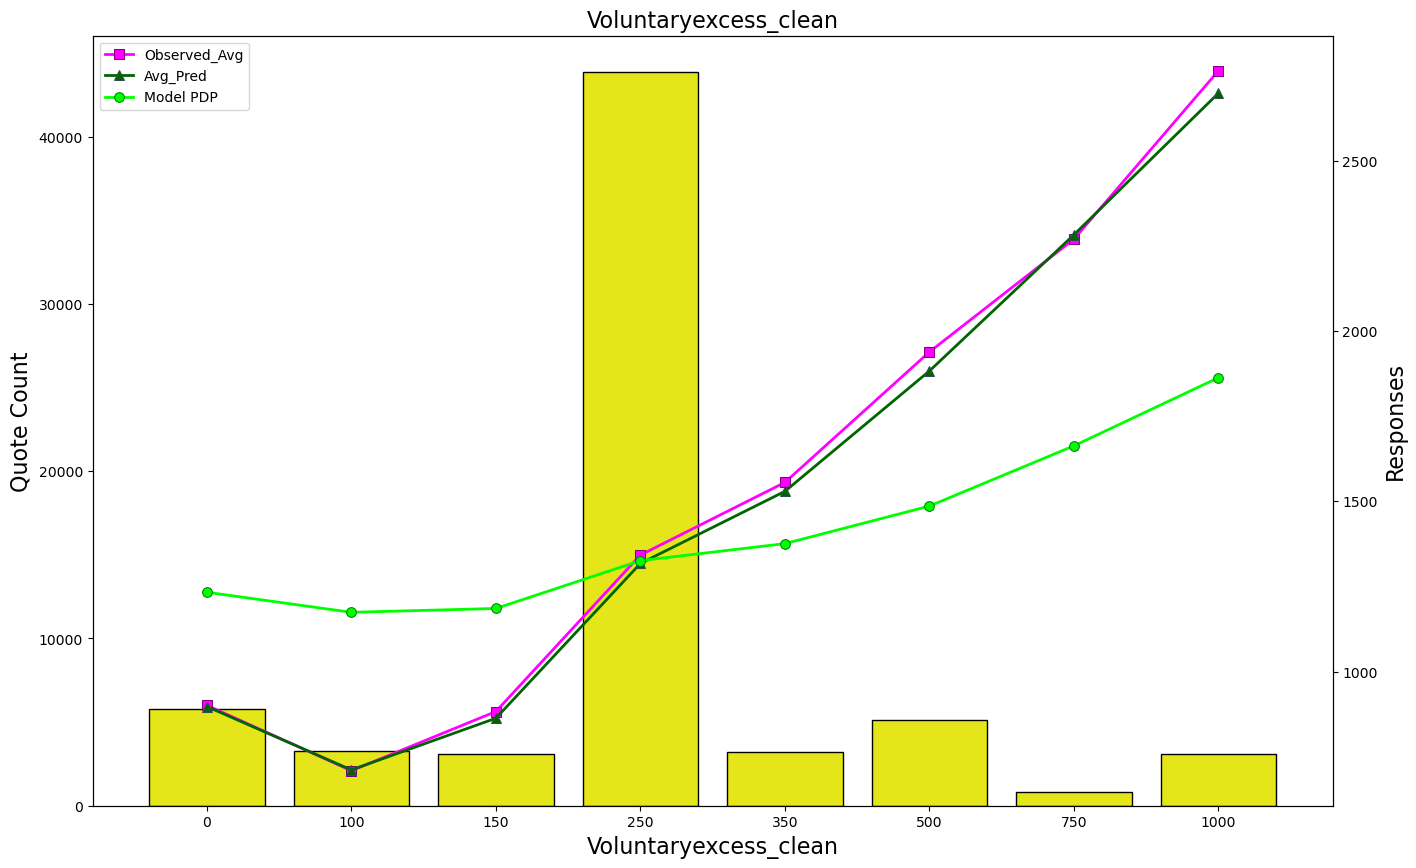

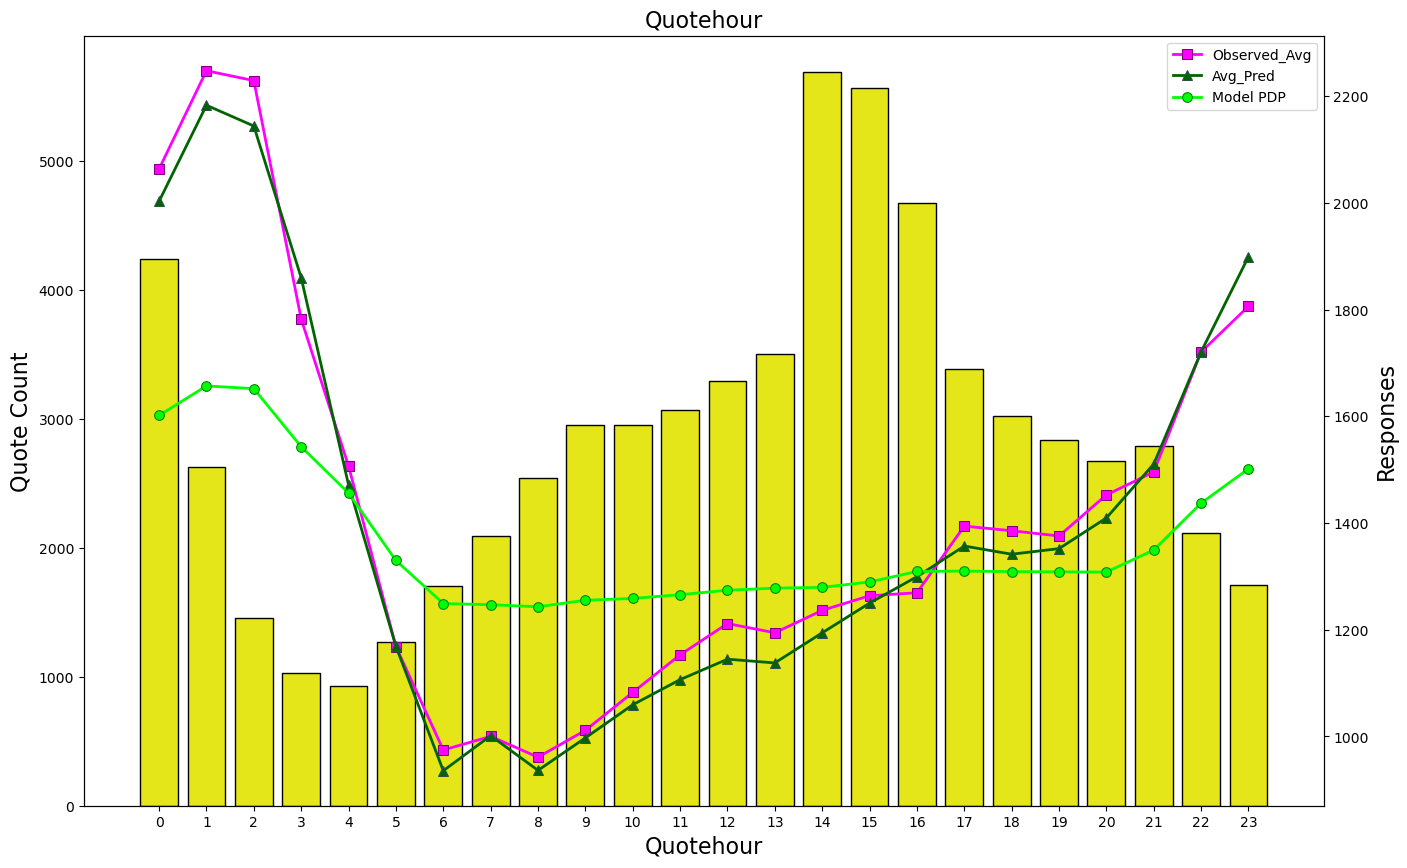

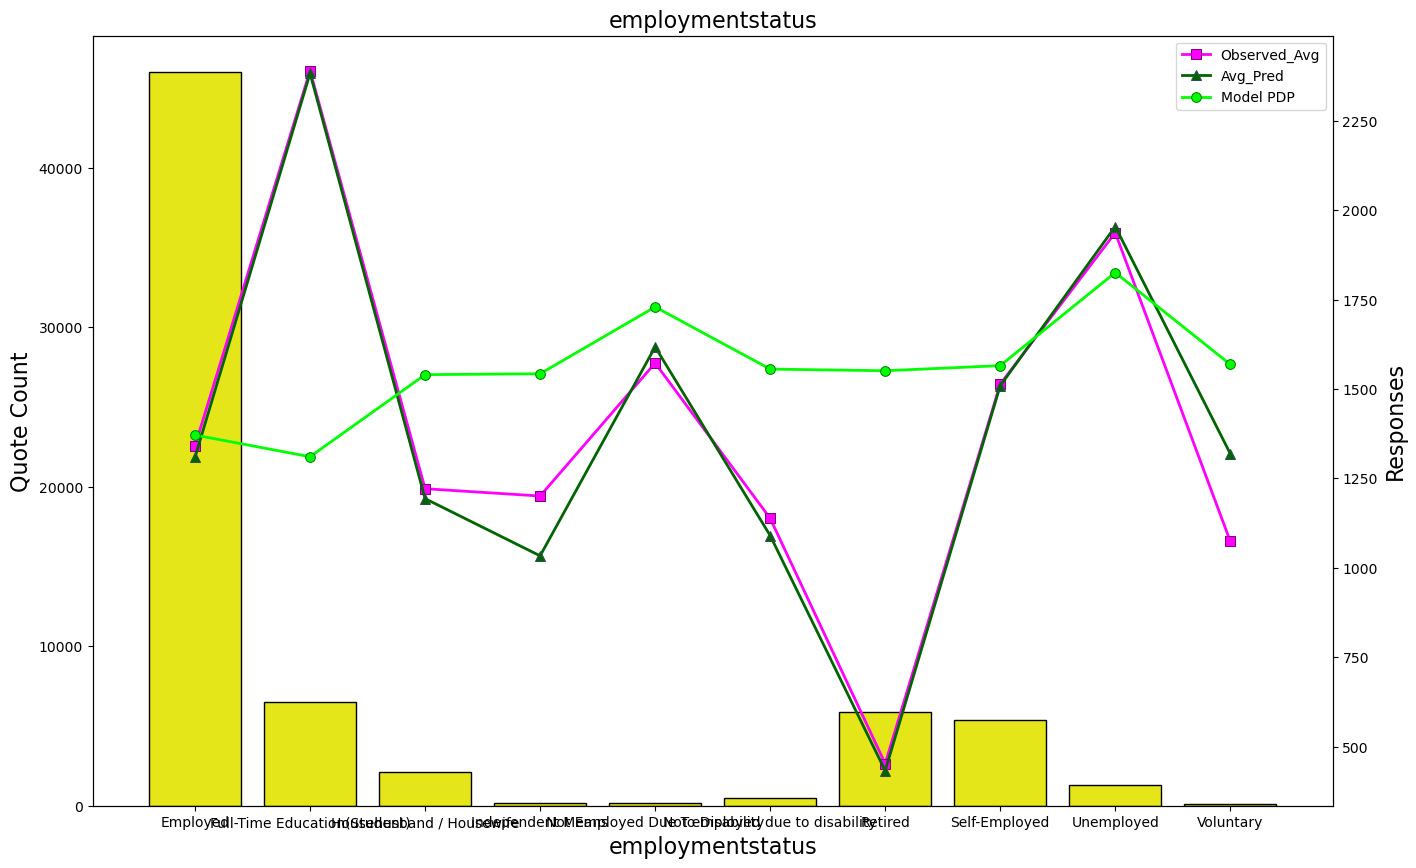

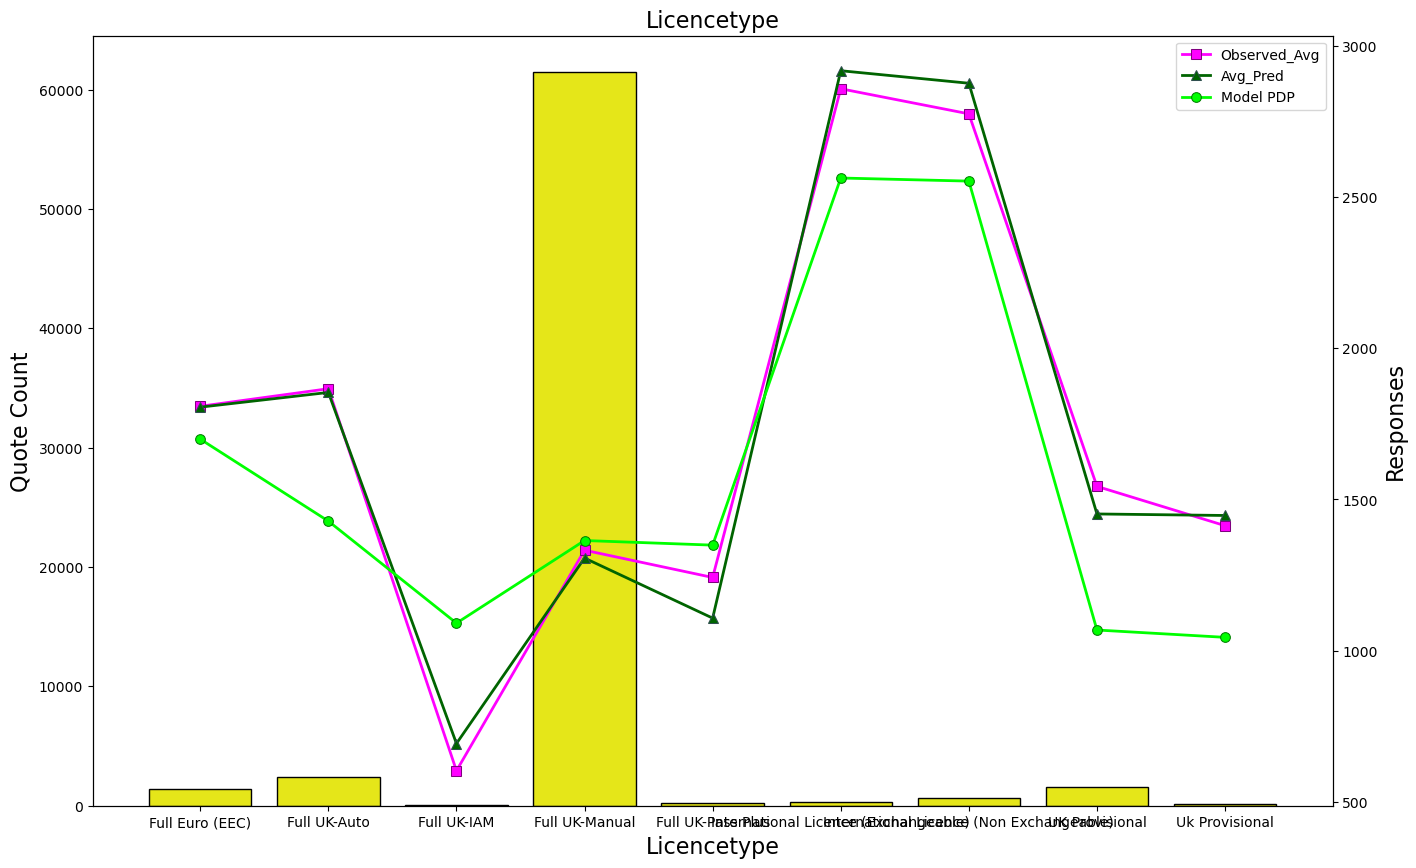

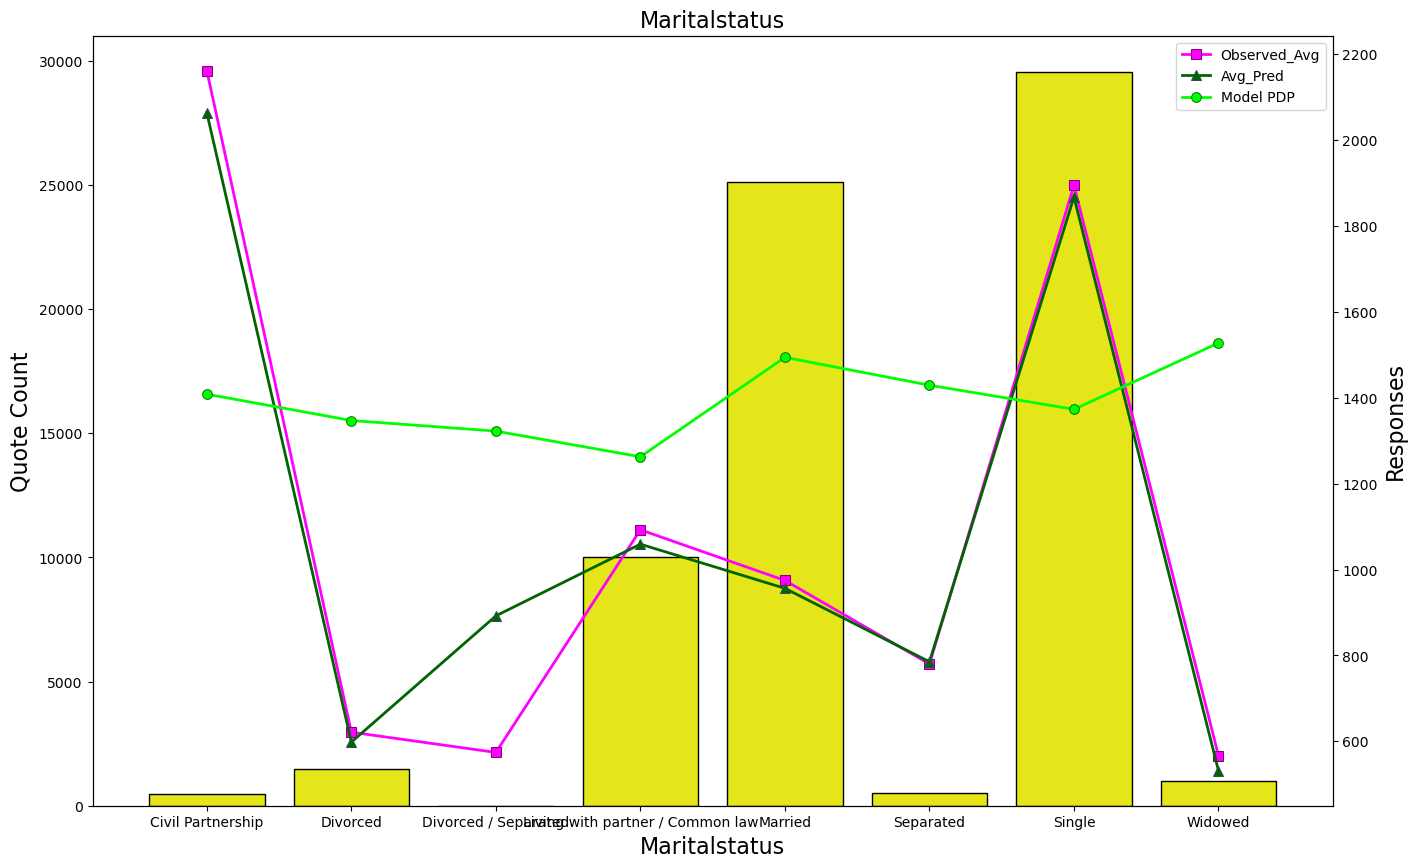

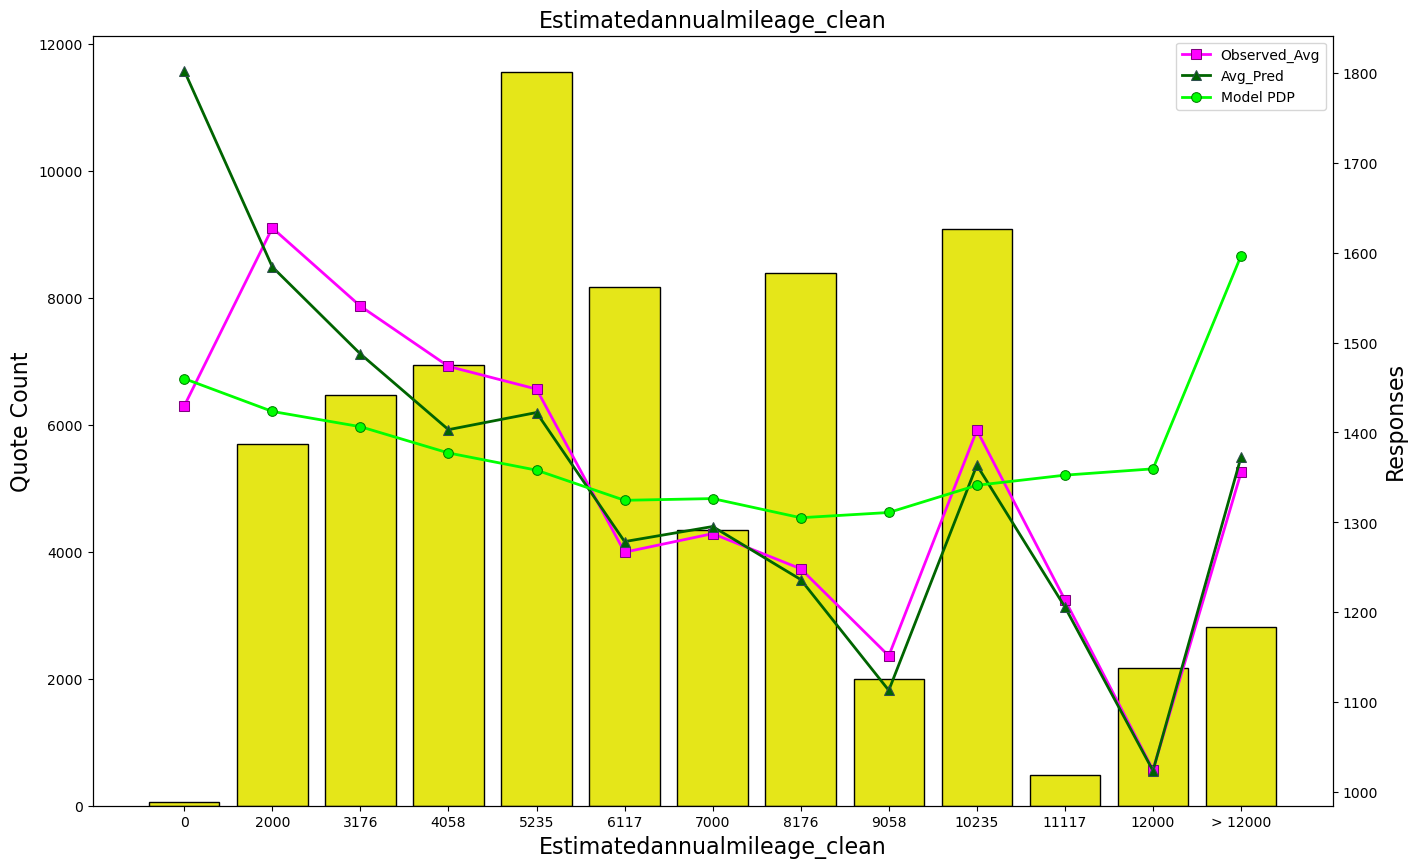

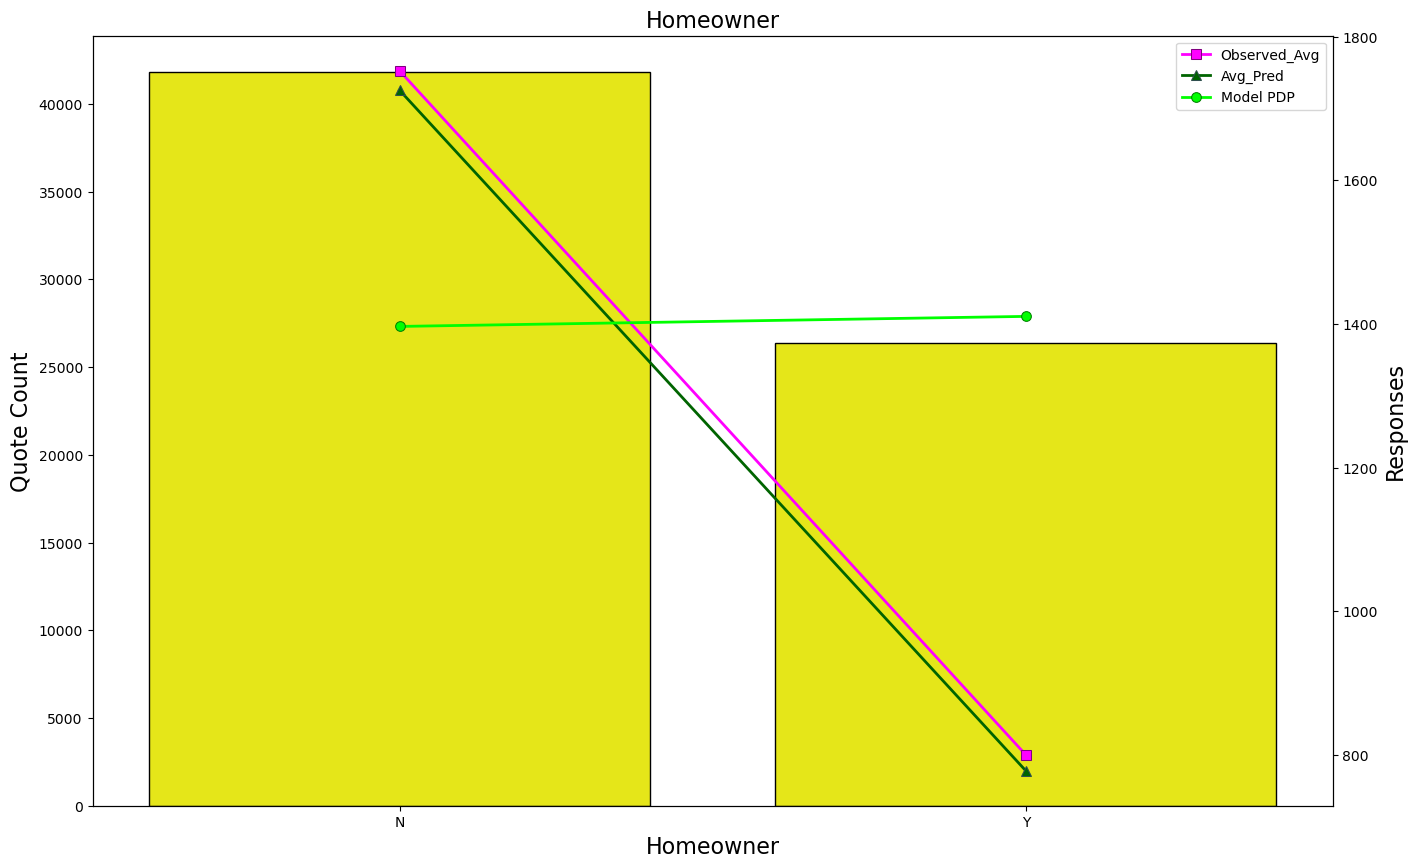

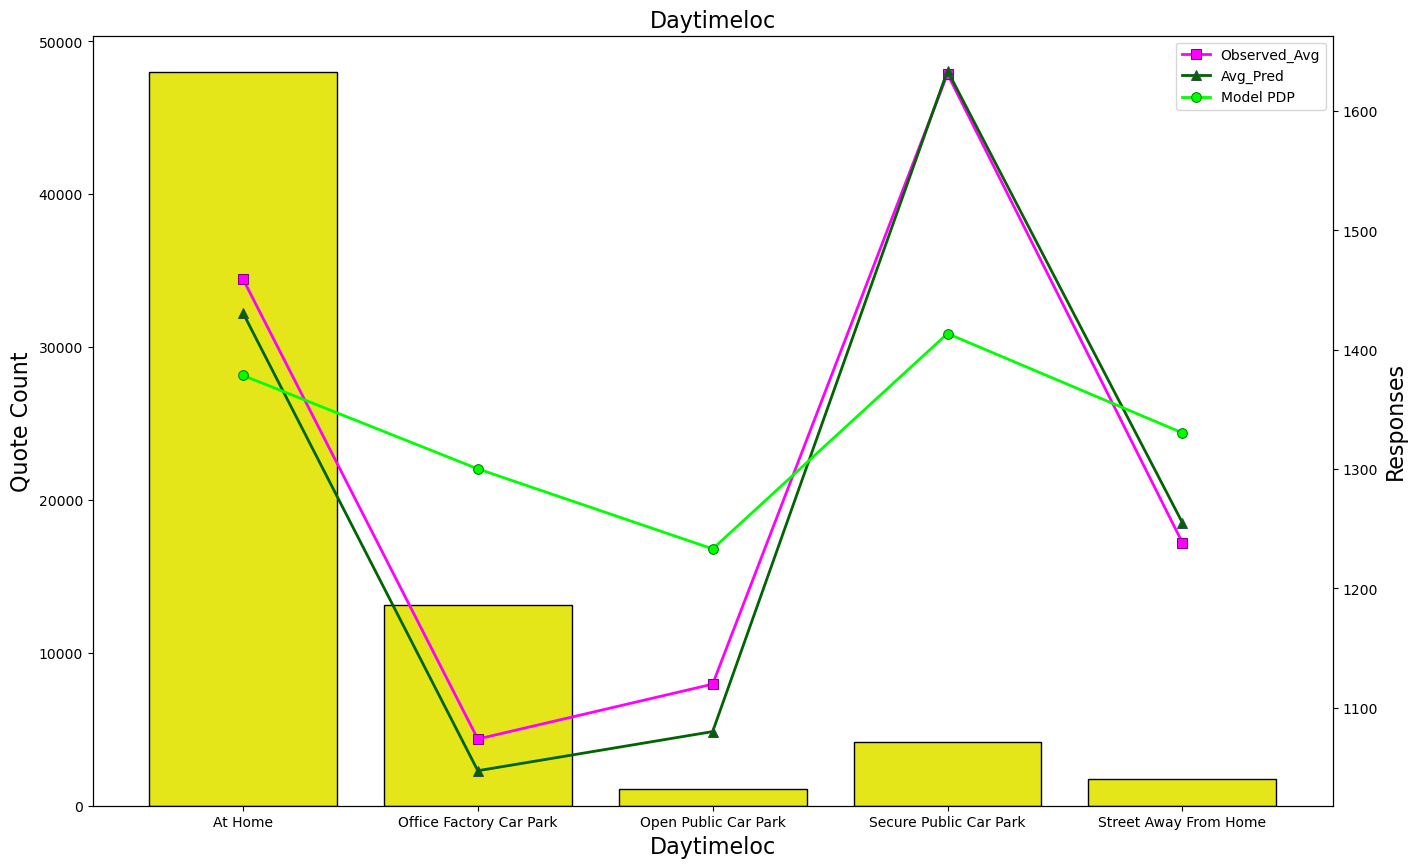

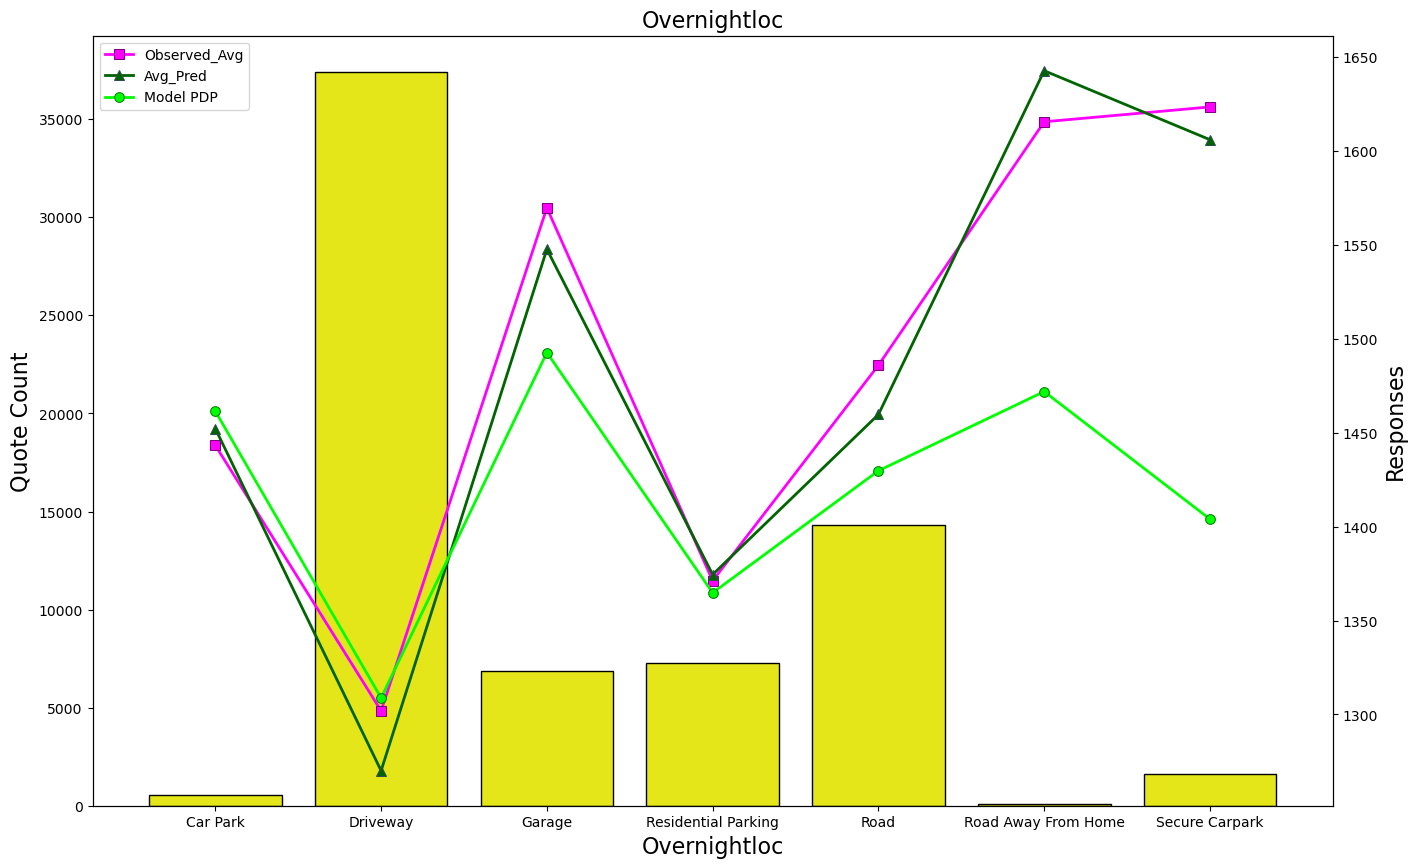

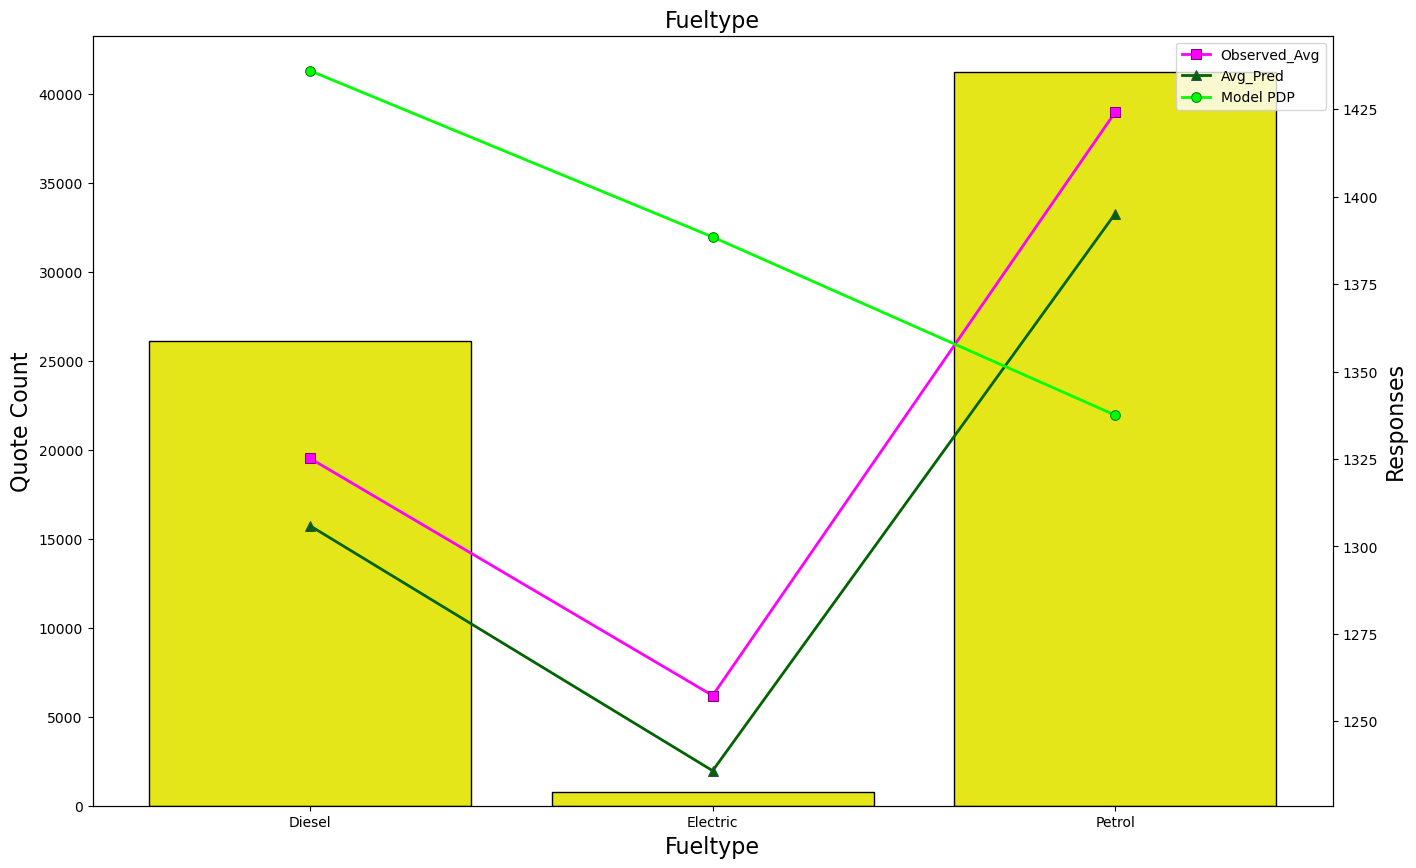

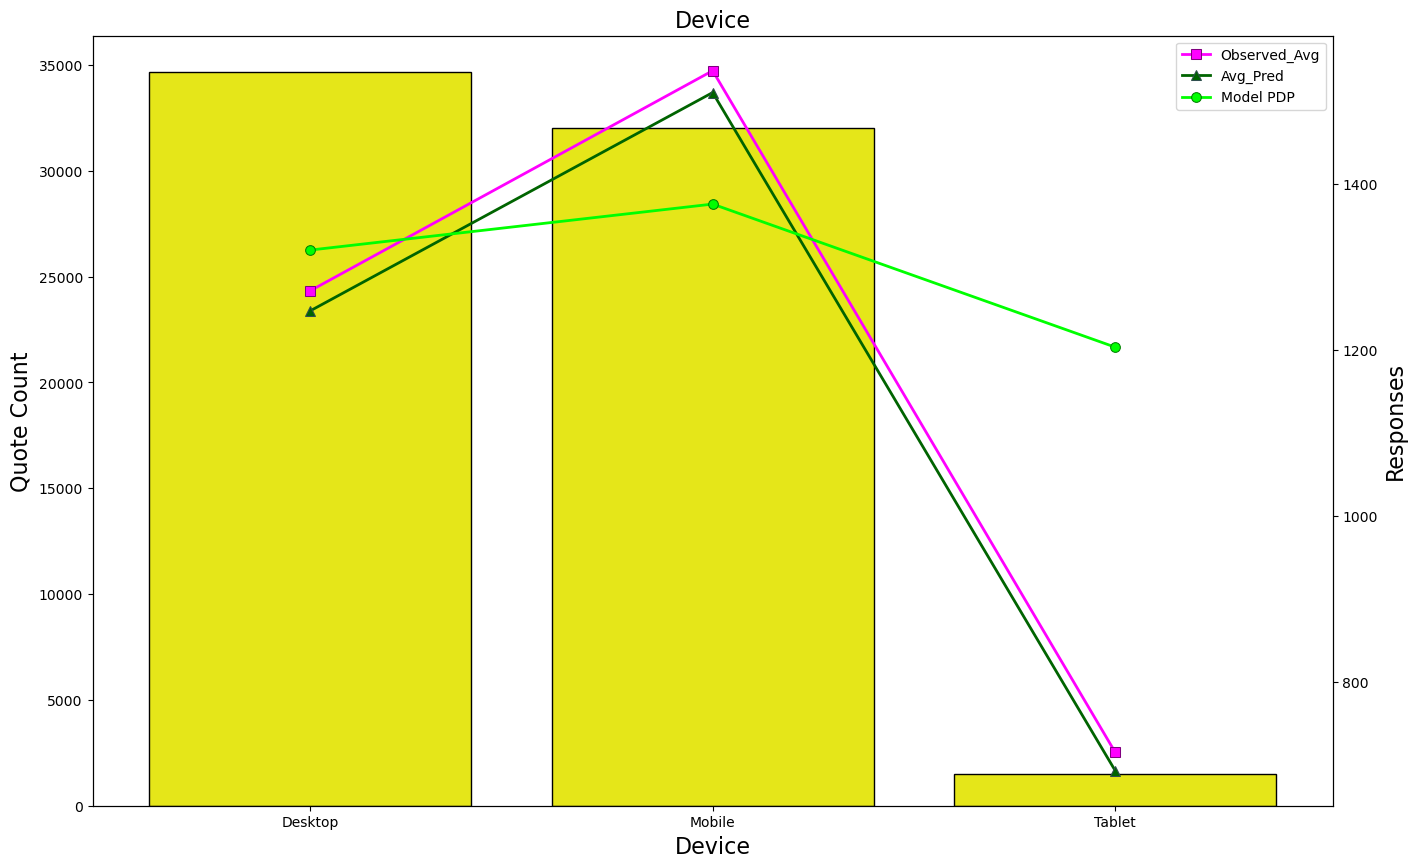

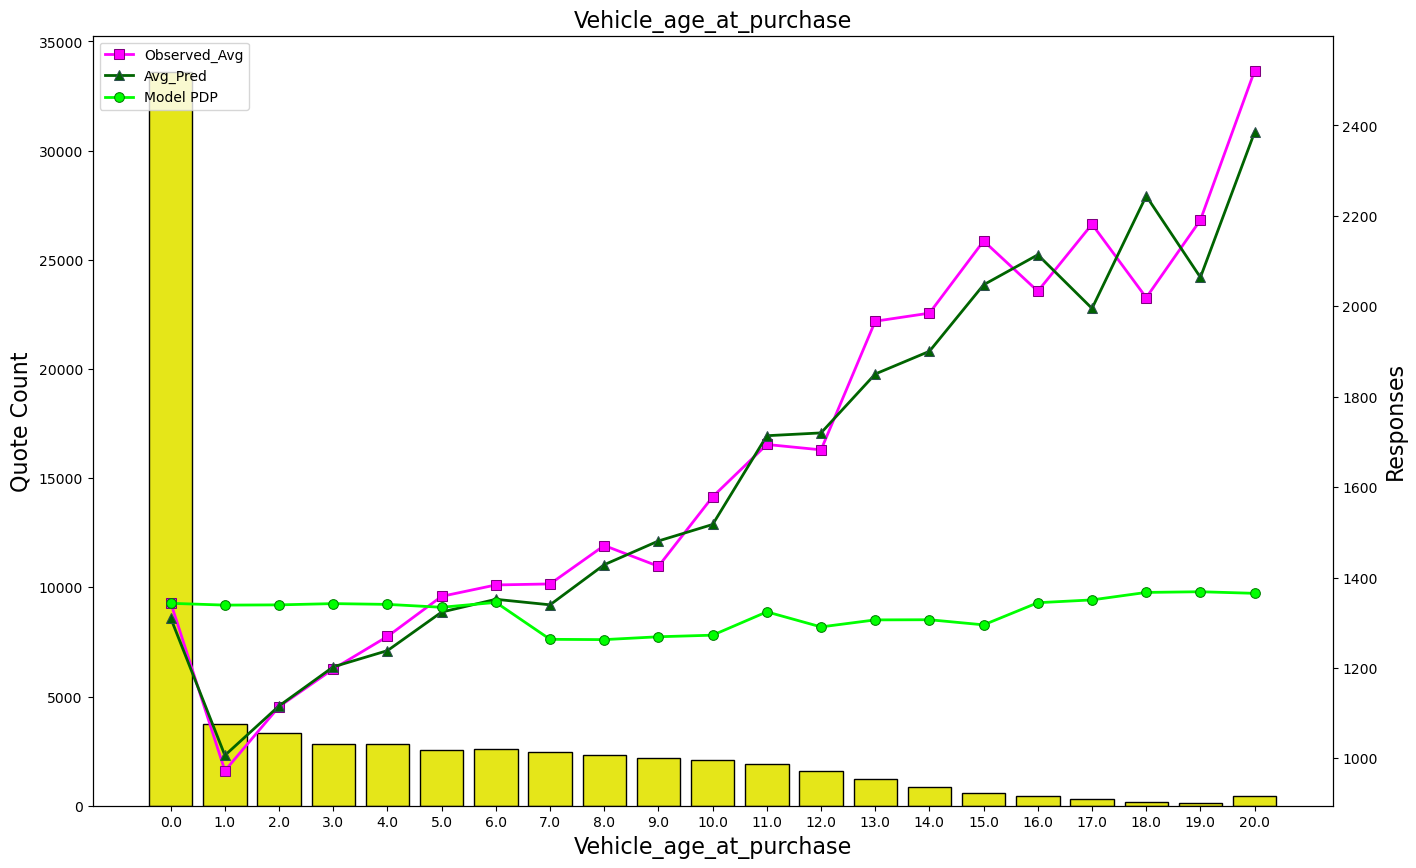

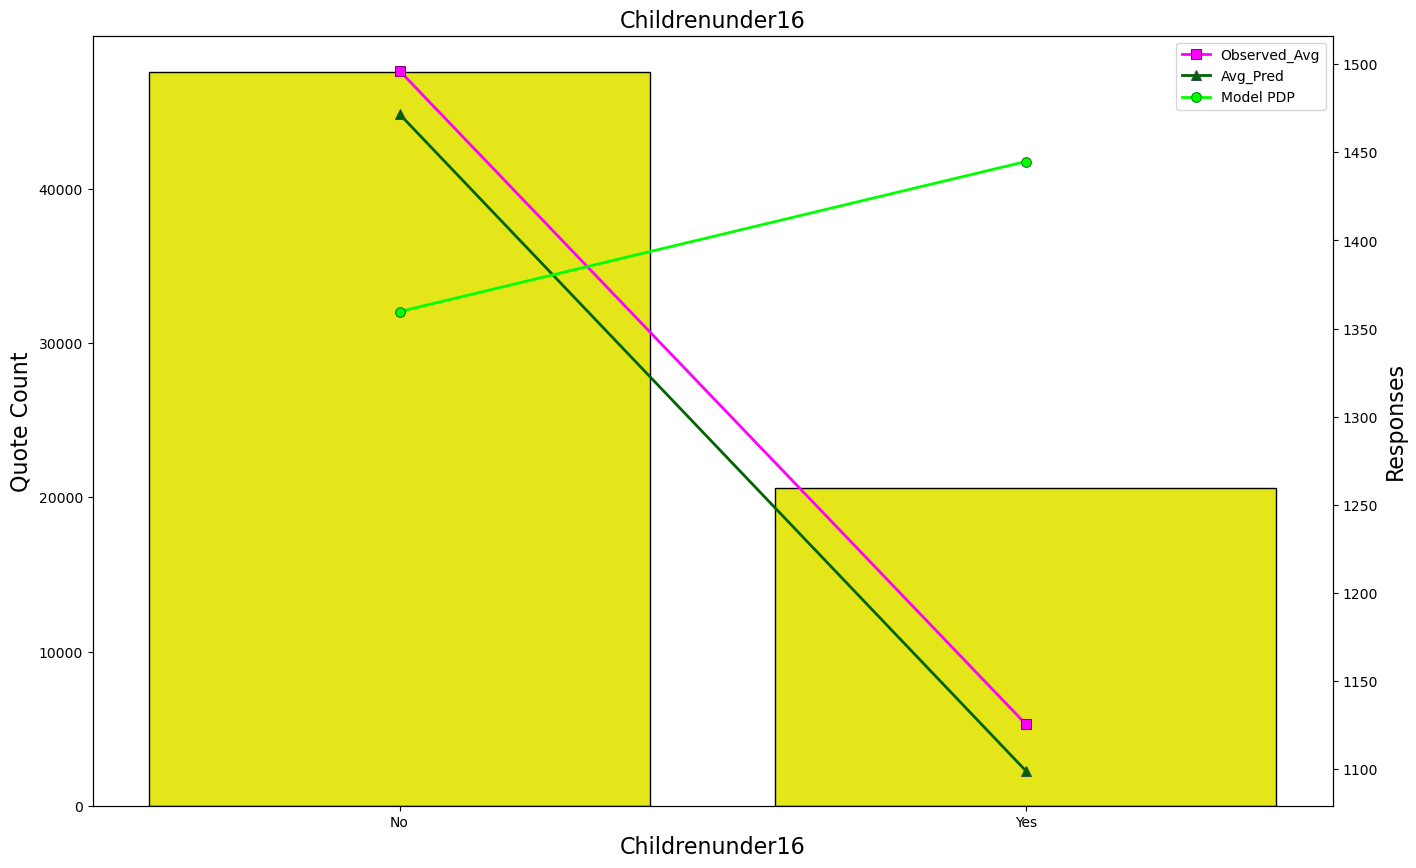

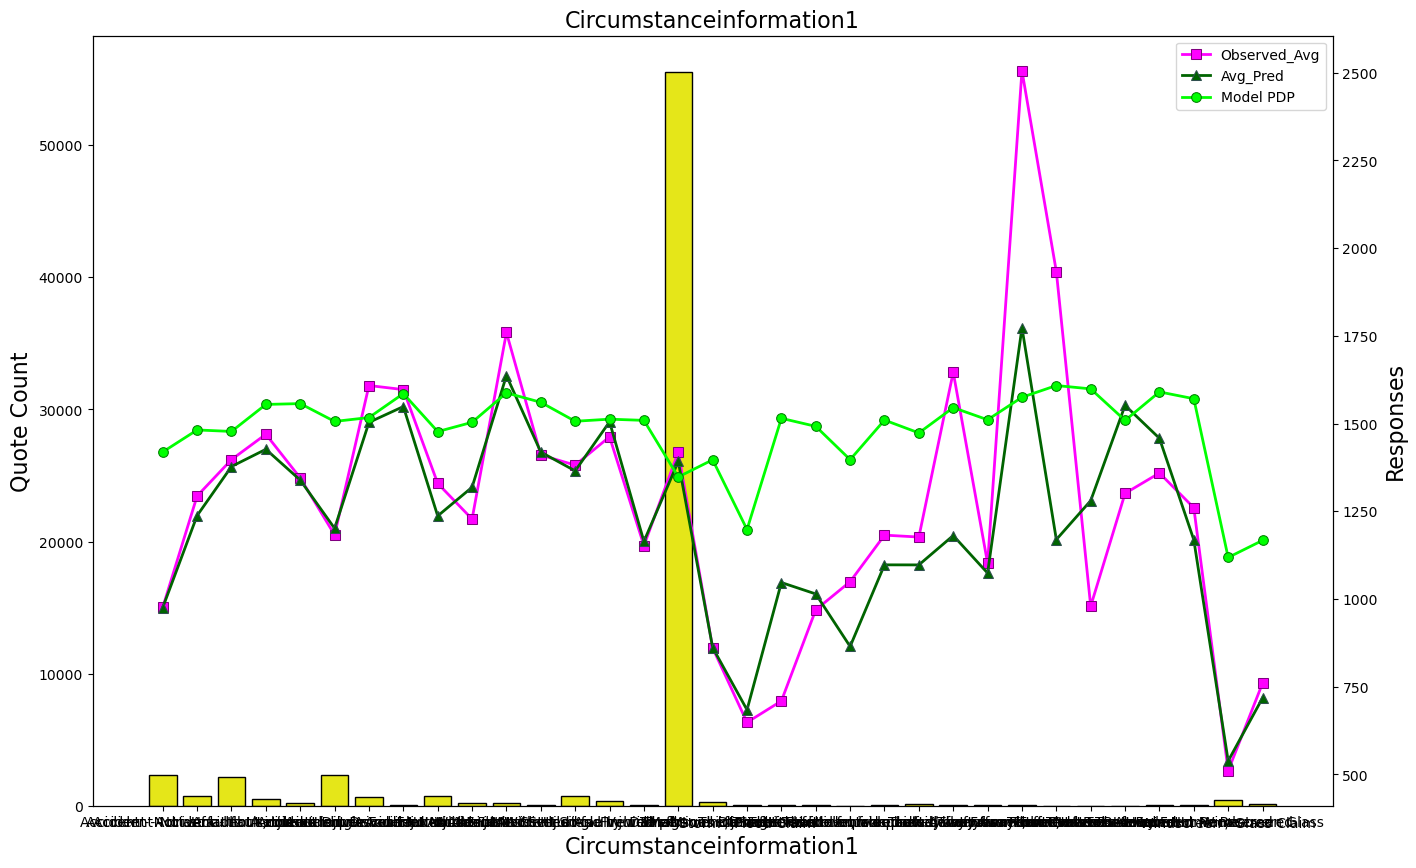

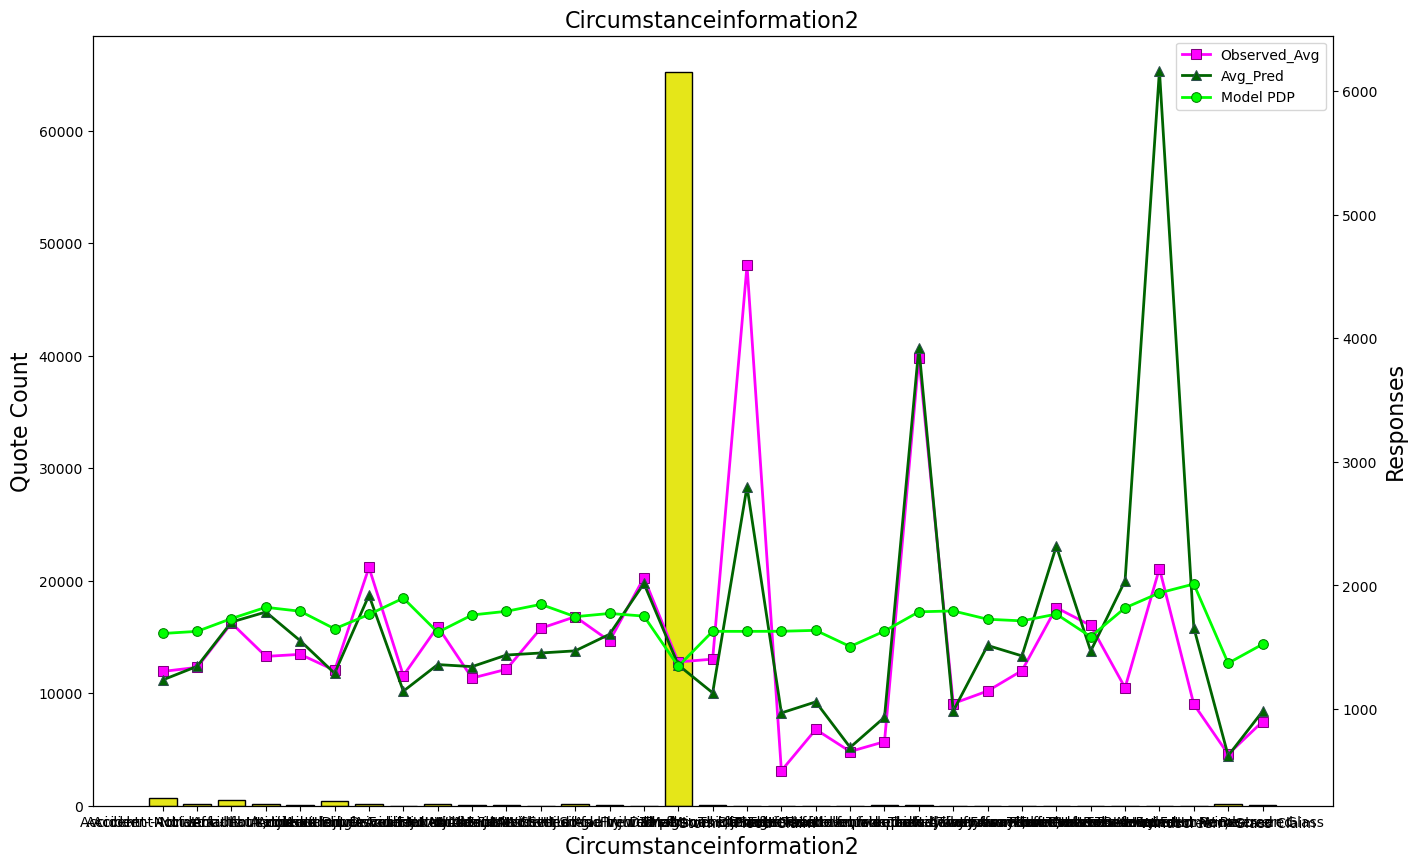

/home/majikthise/miniconda3/envs/takehome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/home/majikthise/miniconda3/envs/takehome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:45: RuntimeWarning: invalid value encountered in divide
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/majikthise/miniconda3/envs/takehome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in multiply
  return bound(*args, **kwds)
/home/majikthise/miniconda3/envs/takehome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in divide
  return bound(*args, **kwds)


In [ ]:
# loop through features in order of importance:
for feat in feature_importances['Feature']:
    feat_summary_plot = interpret_feature(feat_df = test_df[features],
                                          colname = feat,
                                          actuals = test_df[target_col],
                                          preds = test_preds,
                                          model = model,
                                          num_auto_bands = 35)

# Further work



* Additional feature engineering:
    * Custom banding of categorical feature levels (e.g. 'Hydrogen' with 'Electric')
    * Explicit encoding (e.g. one-hot) for categorical features, if not using catboost (which takes care of it for you)
    * Other encoding methods (e.g. target encoding) for high cardinality features
    * Better treatment of missing values (**very important!!**)
    * Include external data (e.g. postcode features)
    * Explicitly encode additional interactions (e.g. age at which licence first obtained)
    * Better treatment of claims columns - number of (fault/non-fault) claims within 1/2/5 years etc
* Hyper-parameter tuning (grid search, or bayesian optimisation)
* Robust feature selection (e.g. using shuffle-feature-importance across multiple model iterations)
* Performance Comparisons against other model types (e.g. GLM)